# <left> $\text{Cognition & Computation - Project (A.Y. 2022-2023)}$ <left>


## 1. Introduction

In this Python Notebook, we will use Convolutional Neural Networks (CNN) to classify satellite images.
In the first part, we build the model and evaluate the performance on test set. Then we will perform linear readout at different level of the model, and we will visualize the feature maps of the developed model. 
To evaluate the robustness of the model, we will add Gaussian noise and plot psychometric curves to see how the CNN responds to small changes in the input. Finally, we will evaluate the response to adversarial attacks using the Fast Gradient Sign Method (FGSM). 
Finally, an autoencoder is trained in order to reconstruct the original images from noisy input and to evaluate that we use the CNN previously created.



The dataset used in this notebook is the EuroSAT dataset, which is a collection of Sentinel-2 satellite images, consisting out of 10 classes with a total of, 27000 labeled images of size (64,64,3). 

The dataset can be found on GitHub at the following link: https://github.com/phelber/eurosat.

| Label | Description |
| --- | --- |
| 0 | AnnualCrop |
| 1 | Forest |
| 2 | HerbaceousVegetation |
| 3 | Highway |
| 4 | Industrial |
| 5 | Pasture |
| 6 | PermanentCrop |
| 7 | Residential |
| 8 | River |
| 9 | SeaLake |



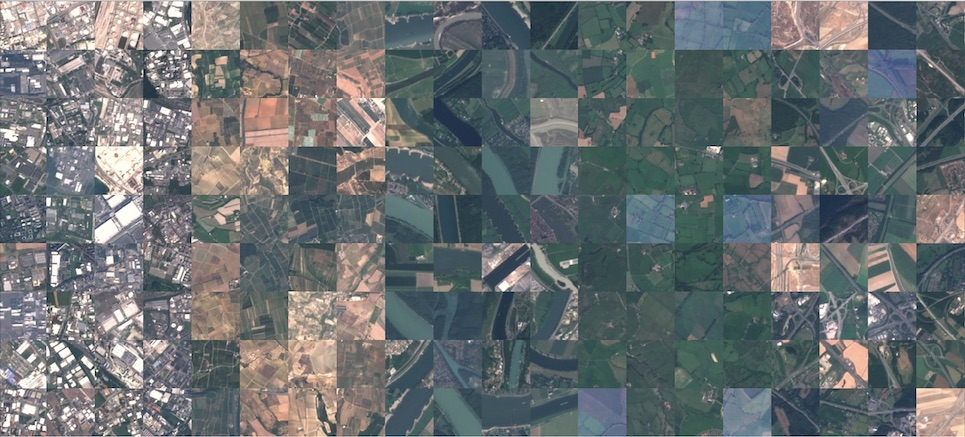




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling eurosat/eurosat/rgb/2.0.0.incomplete4ZK65Y/eurosat-train.tfrecord*...:   0%|          | 0/27000 [00:…

Dataset eurosat downloaded and prepared to ./eurosat/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


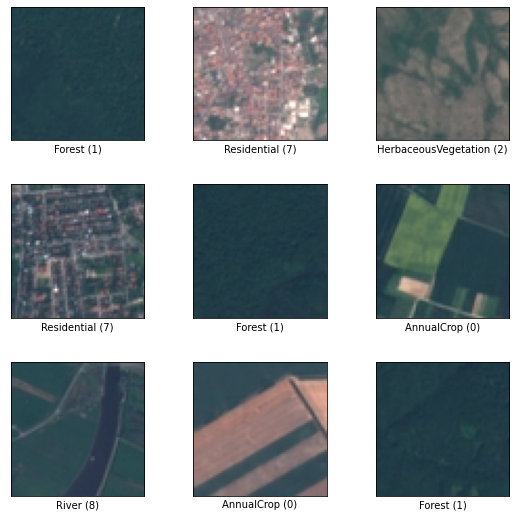

In [ ]:

import tensorflow as tf
import tensorflow_datasets as tfds 
import numpy as np
from locale import normalize
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Reshape, Dropout, Activation, Flatten, Lambda, Rescaling, RandomZoom, BatchNormalization , LeakyReLU, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.regularizers import l2
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam
from keras.metrics import SparseCategoricalAccuracy
from PIL.Image import ID

#Library for feature maps plot
!pip install keract
from keract import get_activations, display_activations

#Set as random seed the ID number
tf.random.set_seed(1079454)
DATA_DIR = "./eurosat"
shuffle=True 

#Import the dataset directly from tensorflow
ds, ds_info = tfds.load('eurosat/rgb',
                        with_info=True,
                        as_supervised=True,
                        split='train',
                        data_dir=DATA_DIR)

labels = np.loadtxt('./eurosat/eurosat/rgb/2.0.0/label.labels.txt', dtype='str')

#All the labels in the dataset 
print(labels)
#Show examples of images in the dataset
fig = tfds.show_examples(ds, ds_info)



Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [3000 3000 3000 2500 2500 2000 2500 3000 2500 3000]


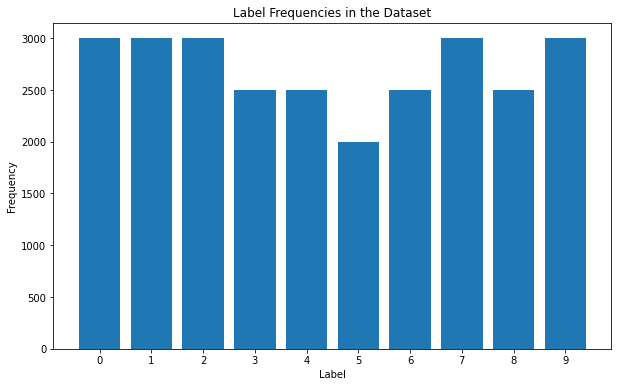

In [ ]:
#Plotting the Label frequencies throught all the dataset
lab, freqs = np.unique(list(map(lambda x: x[1], ds)), return_counts=True)

print("Labels in training dataset: ", lab)
print("Frequencies in training dataset: ", freqs)


def plot_data(labels, frequencies):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(labels, frequencies)
    ax.set_xlabel("Label")
    ax.set_ylabel("Frequency")
    ax.set_title("Label Frequencies in the Dataset")
    ax.set_xticks(range(10))
    plt.show()

plot_data(lab, freqs)

# 2. Data Manipulaation

In this section we prepare the data splitting the entire dataset in training, validation and test:


*   80% for training
*   10% for validation
*   10% for testing




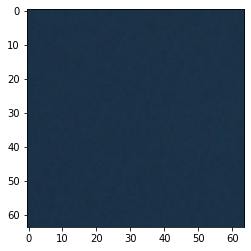

LABEL: 9


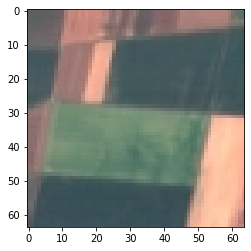

LABEL: 0


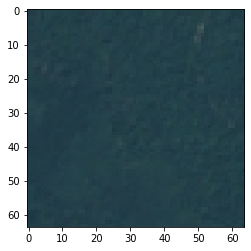

LABEL: 1


In [ ]:

#Split the dataset into training(90%) and test(10%)
train_dataset = ds.take(24300)
test_dataset = ds.skip(24300) 
#Split the training set into training(80% of the total) and validation(10% of the total)
validation_dataset = train_dataset.take(2700)
train_dataset = train_dataset.skip(2700)


#Map feature and label into a list

#Train set size = 21600
X_train = list(map(lambda x: x[0], train_dataset))
y_train = list(map(lambda x: x[1], train_dataset))

#Test set size = 2700
X_test = list(map(lambda x: x[0], test_dataset))
y_test = list(map(lambda x: x[1], test_dataset))

#Validation set size = 2700
X_validation = list(map(lambda x: x[0], validation_dataset))
y_validation = list(map(lambda x: x[1], validation_dataset))


#Plot the first image of each subset and the associated label
plt.imshow(X_train[0],cmap = plt.cm.gray_r,interpolation = "nearest")
plt.show()
print("LABEL: %i"%y_train[0])
plt.imshow(X_test[0],cmap = plt.cm.gray_r,interpolation = "nearest")
plt.show()
print("LABEL: %i"%y_test[0])
plt.imshow(X_validation[0],cmap = plt.cm.gray_r,interpolation = "nearest")
plt.show()
print("LABEL: %i"%y_validation[0])



def plot_data(labels, frequencies):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(labels, frequencies)
    ax.set_xlabel("Label")
    ax.set_ylabel("Frequency")
    ax.set_title("Label Frequencies in the Dataset")
    ax.set_xticks(range(10))
    plt.show()

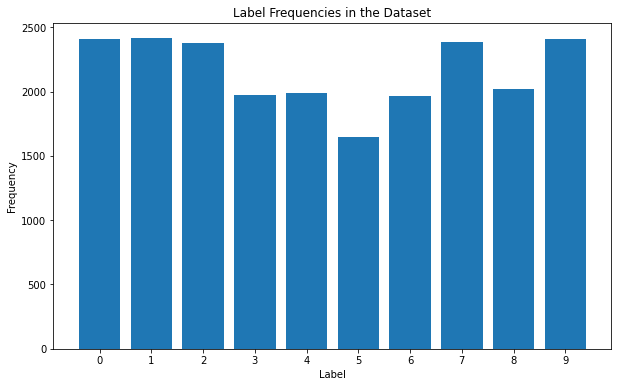

In [ ]:
#Plot the label frequencies for the training set
y_freq, freqs = np.unique(list(map(lambda x: x[1], train_dataset)), return_counts=True)
plot_data(y_freq, freqs)

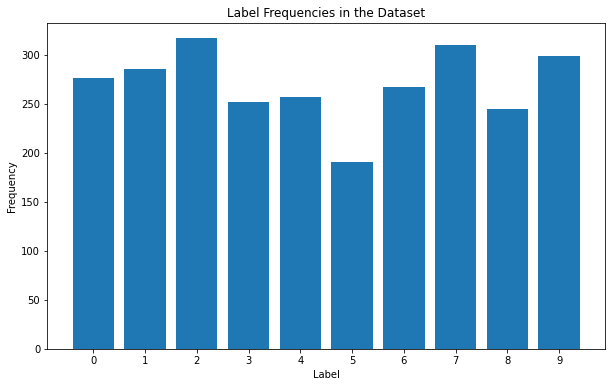

In [ ]:
#Plot the label frequencies for the test set
y_freq, freqs = np.unique(list(map(lambda x: x[1], test_dataset)), return_counts=True)
plot_data(y_freq, freqs)

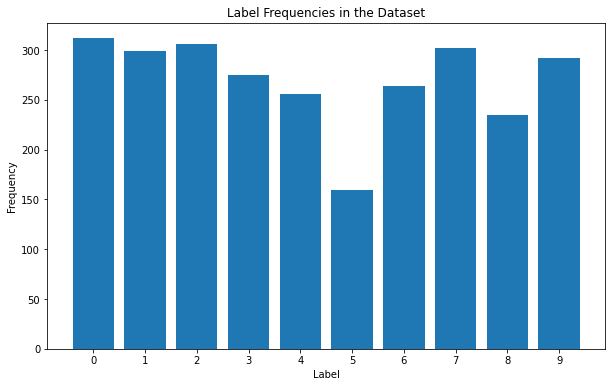

In [ ]:
#Plot the label frequencies for the validation set
y_freq, freqs = np.unique(list(map(lambda x: x[1], validation_dataset)), return_counts=True)
plot_data(y_freq, freqs)

## 2.1 Data normalization

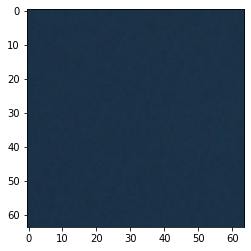

LABEL: 9


In [ ]:

#ensure that all image pixels are in range between 0 and 1
def normalize_features(vector):
  return np.array(vector, dtype=np.float32)/255.0

#transform the label from tensor to a np.array
def convert_label(vector):
  return np.array(vector, dtype=np.int32)

#normalize train, validation and test set
X_train_norm = normalize_features(X_train)
X_validation_norm = normalize_features(X_validation)
X_test_norm = normalize_features(X_test)

#convert labels in train, validation and test set
y_train_conv=convert_label(y_train)
y_test_conv=convert_label(y_test)
y_validation_conv=convert_label(y_validation)


#plot the first image from the training set normalized and the first converted label
plt.imshow(X_train_norm[0],cmap= plt.cm.gray_r,interpolation = "nearest")
plt.show()
print("LABEL: %i"%y_train_conv[0])

X_train.clear()
y_train.clear()

X_test.clear()
y_test.clear() 

X_validation.clear() 
y_validation.clear() 



# 3. Model Definition

In this section, we defined and trained the model.
We chose a convolutional Neural Network because it is often used in deep learning for image classification tasks. The model architecture is composed by:

* 4 convolutional layers with filter size of 128, 64, 64, 32, each one has a 3×3 kernel and the function 'relu' is used as activation function.
* Each convolutional layer is followed by a max 2 dimensions pooling layer of default size.
* Flatten layer that converts the output of the convolution in a one dimension vector.
* A fully connected layer composed of 256 neurons that should add learning capacity to the previous convolutional layers in order to make more accurate final classification.
* A dropout layer is used to reduce overfitting during the training process, 'turning off' half of the neurons and preventing the model from relying too much on some set of input features.
* A fully connected layer composed of 10 neurons is used as output layer by the fact that there are 10 different classes in the dataset

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_conv2D (Conv2D)       (None, 62, 62, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 128)      0         
 )                                                               
                                                                 
 second_conv2D (Conv2D)      (None, 29, 29, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 third_conv2D (Conv2D)       (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

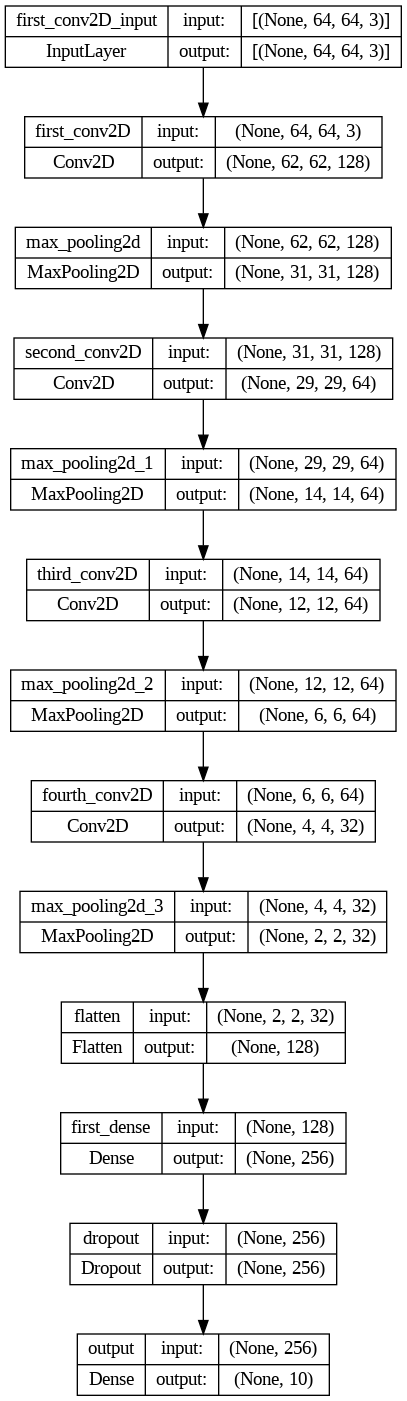

In [ ]:
#Define the batch size in order to take 64 samples at each training iteration, tipically these are of size: 32,64,128,256
BATCH_SIZE=64

#Define the CNN model using 
model_CNN = tf.keras.Sequential([
  Conv2D(128, kernel_size=3, activation='relu',input_shape=(64,64,3), name='first_conv2D'),
  MaxPooling2D(),
  Conv2D(64, kernel_size=3, activation='relu', name='second_conv2D'),
  MaxPooling2D(),
  Conv2D(64, kernel_size=3, activation='relu', name='third_conv2D'),
  MaxPooling2D(),
  Conv2D(32, kernel_size=3, activation='relu',name='fourth_conv2D'),
  MaxPooling2D(),
  Flatten(),
  Dense(256, activation='relu',name='first_dense'),
  Dropout(0.5),
  Dense(10,activation="softmax",name='output')
])

#Define early stopping technique to prevent overfitting by stopping the process when validation loss starts to increase and restoring the best parameters found
early_stopping = EarlyStopping(monitor='val_loss', verbose=True, patience=5, min_delta=0.0001, restore_best_weights=True)

#Define the reduction of learning rate when the validation loss increase 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0000001, verbose=1)

model_CNN.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['SparseCategoricalAccuracy'])

#Plot model architecture
model_CNN.summary()
plot_model(model_CNN, show_shapes=True, show_layer_names=True)





In [ ]:
#Train the model for 30 epochs using a batch size of 64, implementing early stopping and reduction of learning rate technique
model_CNN_results = model_CNN.fit(x=X_train_norm,y=y_train_conv,
                                  batch_size=BATCH_SIZE,
                                  validation_data=(X_validation_norm,y_validation_conv),
                                  epochs=30, 
                                  callbacks=[early_stopping,reduce_lr])


Epoch 1/30
338/338 [==============================] - 17s 20ms/step - loss: 1.5532 - sparse_categorical_accuracy: 0.3974 - val_loss: 1.0973 - val_sparse_categorical_accuracy: 0.5919 - lr: 0.0010
Epoch 2/30
338/338 [==============================] - 6s 18ms/step - loss: 1.0520 - sparse_categorical_accuracy: 0.6193 - val_loss: 0.9156 - val_sparse_categorical_accuracy: 0.6889 - lr: 0.0010
Epoch 3/30
338/338 [==============================] - 6s 18ms/step - loss: 0.8850 - sparse_categorical_accuracy: 0.6845 - val_loss: 0.8297 - val_sparse_categorical_accuracy: 0.6989 - lr: 0.0010
Epoch 4/30
338/338 [==============================] - 6s 18ms/step - loss: 0.7958 - sparse_categorical_accuracy: 0.7159 - val_loss: 0.7896 - val_sparse_categorical_accuracy: 0.7122 - lr: 0.0010
Epoch 5/30
338/338 [==============================] - 6s 18ms/step - loss: 0.7186 - sparse_categorical_accuracy: 0.7435 - val_loss: 0.7780 - val_sparse_categorical_accuracy: 0.7093 - lr: 0.0010
Epoch 6/30
338/338 [=========

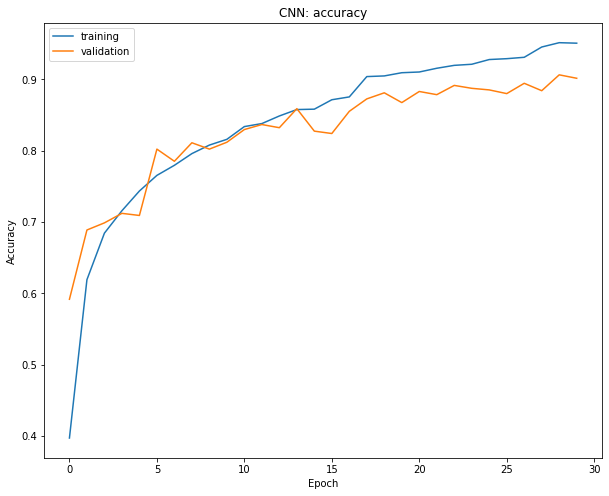

In [ ]:
#Store the accuracy of the training and validation set
training_accuracy = model_CNN_results.history['sparse_categorical_accuracy']
validation_accuracy = model_CNN_results.history['val_sparse_categorical_accuracy']

#Accuracy history for training and validation
plt.figure(figsize=(10, 8))
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title('CNN: accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

After 30 epochs, we obtained an accuracy on the training set around the 93% and around the 90% for the validation set. So the architecture of the CNN seems correct for this type of classification, considering also the fact that it has less than 170 thousand parameters.

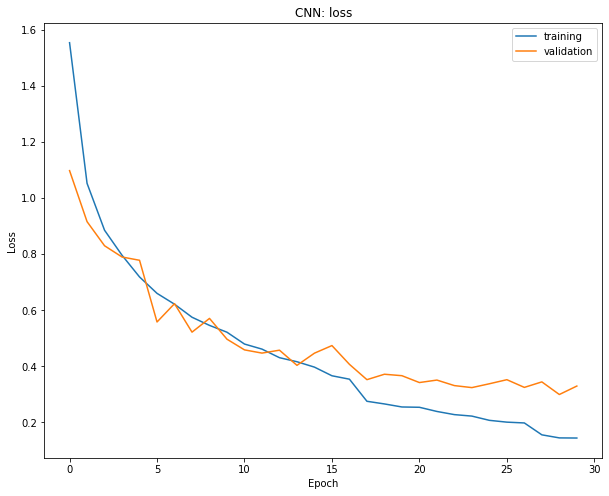

In [ ]:
#Store the loss of the training and validation set
training_loss = model_CNN_results.history['loss']
validation_loss = model_CNN_results.history['val_loss']

#Loss history for training and validation
plt.figure(figsize=(10, 8))
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('CNN: loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In the same way of the accuracy, the loss of the training set has constantly decreased while the validation one had a few spikes but in general it decrease.

In [ ]:
#Evaluate the CNN performance on the test set
res_test=model_CNN.evaluate(X_test_norm,y_test_conv)

85/85 [==============================] - 0s 5ms/step - loss: 0.3099 - sparse_categorical_accuracy: 0.9007


As the validation test was suggesting also the loss and accuracy of the model on the test set are relevant. In fact, we can say that the model learn to distinguish the different terrain composition of the dataset.

85/85 [==============================] - 0s 3ms/step
Confusion Matrix


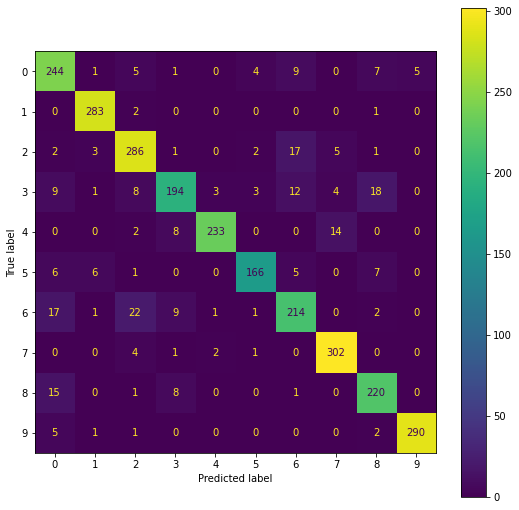

In [ ]:
#Function used to plot the confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels):
  print('Confusion Matrix')
  cm=ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels)
  fig = cm.figure_
  fig.set_figwidth(9)
  fig.set_figheight(9) 

#Predict the label and comparing them with the true labels
Y_pred=model_CNN.predict(X_test_norm)
y_pred = np.argmax(Y_pred, axis=1).astype(int)
plot_confusion_matrix(y_test_conv.astype(int), y_pred)

The confusion matrix suggest us that the model has performed well across almost all categories. We can observe that the most misclassified features are the ones with label 6, so the model has not complete correctly learned to distinguish between this and other features.

The other category that has more misclassified samples is the fifth, but this could be caused by the fact that we have fewer samples both in training and test set compared with others.

# 4. Linear Read-outs
The use of hidden representations and linear readouts allows the analysis of the internal representation of the data and the evaluation of the model's ability to learn disentangled representations for the prediction task. By examining the hidden representations at different levels of the network, we can investigate whether the model learns increasingly more disentangled representations in deeper layers, which could potentially lead to better prediction performance.

A disentangled representation means that each feature or aspect of the data is represented by a separate and independent set of neurons, which allows the model to manipulate and reason about these features in a more interpretable and efficient way.


First of all we need to extract the hidden representation from the CNN layers. 


In [ ]:
#Function used to extract the hidden representation given the layer names of the network and the input features
def get_hidden_representations(layer_names, input_features):
    hidden_representations = {}
    #Create an hidden representation for each layer in layer_names
    for layer_name in layer_names:
        
        hidden_representation_model = tf.keras.Model(inputs=model_CNN.input,
                                            outputs=model_CNN.get_layer(layer_name).output,
                                            name=layer_name)
        # Compute the hidden representations.
        hidden_representation = hidden_representation_model.predict(input_features)
        hidden_representations[layer_name] = hidden_representation
    return hidden_representations


In [ ]:
#Class used to initialize a linear model given the hidden representation
class LinearModel(tf.keras.Model):
  def __init__(self, layer_size, n_units=10):
    super().__init__()
    # Create a dense layer with 10 neurons and input shape equal to layer size.
    self.linear = tf.keras.layers.Dense(10, input_shape=(layer_size,), activation='linear')
  # Override the call method to define the forward pass of the model.
  def call(self, x):
    return self.linear(x)

In [ ]:
#We will take hidden representation for the third, fourth and for the last fully connected layer 
layer_names_CNN = [ 'third_conv2D','fourth_conv2D','first_dense']
train_hidden_representations_CNN = get_hidden_representations(layer_names_CNN, X_train_norm)

675/675 [==============================] - 2s 2ms/step


In [ ]:
#Get size layer and initialize LinearModel class for each layer considered

layer_size = model_CNN.get_layer(name='third_conv2D').input_shape[1]
linear_third_conv2D = LinearModel(layer_size)

layer_size = model_CNN.get_layer(name='fourth_conv2D').input_shape[1]
linear_fourth_conv2D = LinearModel(layer_size)

layer_size = model_CNN.get_layer(name='first_dense').input_shape[1]
linear_first_Dense = LinearModel(layer_size)

In [ ]:
#Function to train Linear Read-Outs and return the computed loss over the epochs
def train_linear_readout(linear_readout, hidden_reprs, targets, layer_type='conv', epochs=500):
  # Define the optimizer and loss function.
  optimizer = tf.keras.optimizers.Adam()
  computed_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  #Store the computed loss in each epoch into an array
  loss_history=[]
  # Compile the linear readout
  linear_readout.compile(optimizer=optimizer, loss=computed_loss)

  for epoch in range(epochs):
    with tf.GradientTape() as tape:
      # Make predictions 
      predictions = linear_readout(hidden_reprs)
      if layer_type == 'conv':
        # Extract the first element in order to obtain a tensor of appropriate dimension
        predictions_decoded = predictions[:, 0, 0]
      elif layer_type == 'dense':
        predictions_decoded = predictions

      #Compute the loss
      loss = computed_loss(targets, predictions_decoded)
    loss_history.append(loss)
    # Compute the gradients
    gradient = tape.gradient(loss, linear_readout.trainable_variables)
    # Apply the gradien
    optimizer.apply_gradients(zip(gradient, linear_readout.trainable_variables))

    if epoch % 50 == 0:
      print("epoch: {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss.numpy()))
  print("epoch: {:3d}/{}, loss = {:.4f}".format(500, epochs, loss_history[499].numpy()))
  return loss_history

In [ ]:
#train_convolutional_layer(linear_third_conv2D, train_hidden_representations_CNN['third_conv2D'], y_train_conv)
third_conv2D_readout = train_linear_readout(linear_third_conv2D, train_hidden_representations_CNN['third_conv2D'],y_train_conv,layer_type='conv')

epoch:   1/500, loss = 2.3349
epoch:  51/500, loss = 2.2307
epoch: 101/500, loss = 2.1411
epoch: 151/500, loss = 2.0628
epoch: 201/500, loss = 1.9939
epoch: 251/500, loss = 1.9328
epoch: 301/500, loss = 1.8785
epoch: 351/500, loss = 1.8301
epoch: 401/500, loss = 1.7869
epoch: 451/500, loss = 1.7480
epoch: 500/500, loss = 1.7137


In [ ]:
#train_convolutional_layer(linear_fourth_conv2D, train_hidden_representations_CNN['fourth_conv2D'], y_train_conv)
fourth_conv2D_readout_results = train_linear_readout(linear_fourth_conv2D, train_hidden_representations_CNN['fourth_conv2D'],y_train_conv,layer_type='conv')

epoch:   1/500, loss = 2.2805
epoch:  51/500, loss = 2.0982
epoch: 101/500, loss = 1.9407
epoch: 151/500, loss = 1.8050
epoch: 201/500, loss = 1.6882
epoch: 251/500, loss = 1.5878
epoch: 301/500, loss = 1.5012
epoch: 351/500, loss = 1.4263
epoch: 401/500, loss = 1.3612
epoch: 451/500, loss = 1.3044
epoch: 500/500, loss = 1.2555


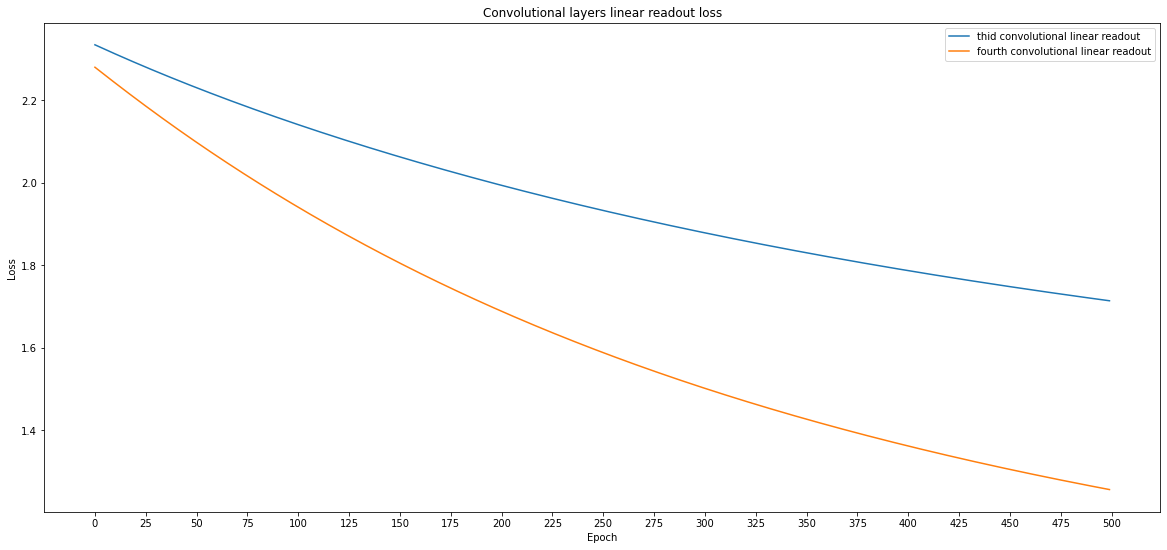

In [ ]:

#Loss history for the convolutional layers
plt.figure(figsize=(20, 9))
plt.plot(third_conv2D_readout)
plt.plot(fourth_conv2D_readout_results)
plt.title('Convolutional layers linear readout loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, len(fourth_conv2D_readout_results)+1, 25))
plt.legend(['thid convolutional linear readout','fourth convolutional linear readout'])
plt.show()



Both the convolutional layers linear readout have a constantly decreasing loss. 
The third one starts with a lower loss but ends with a higher one, while the fourth one starts with a higher value of loss and ends with a lower loss compared to the other one.
This behavior is what we expected because it means that the model gradually learns to make correct classification as it descends in the deepest layer of the architecture.


In [ ]:
#train_dense_layer(linear_first_Dense, train_hidden_representations_CNN['first_dense'], y_train_conv)
first_dense_readout_results = train_linear_readout(linear_first_Dense, train_hidden_representations_CNN['first_dense'],y_train_conv,layer_type='dense')

epoch:   1/500, loss = 2.3882
epoch:  51/500, loss = 0.5677
epoch: 101/500, loss = 0.3265
epoch: 151/500, loss = 0.2474
epoch: 201/500, loss = 0.2075
epoch: 251/500, loss = 0.1834
epoch: 301/500, loss = 0.1672
epoch: 351/500, loss = 0.1556
epoch: 401/500, loss = 0.1469
epoch: 451/500, loss = 0.1401
epoch: 500/500, loss = 0.1347


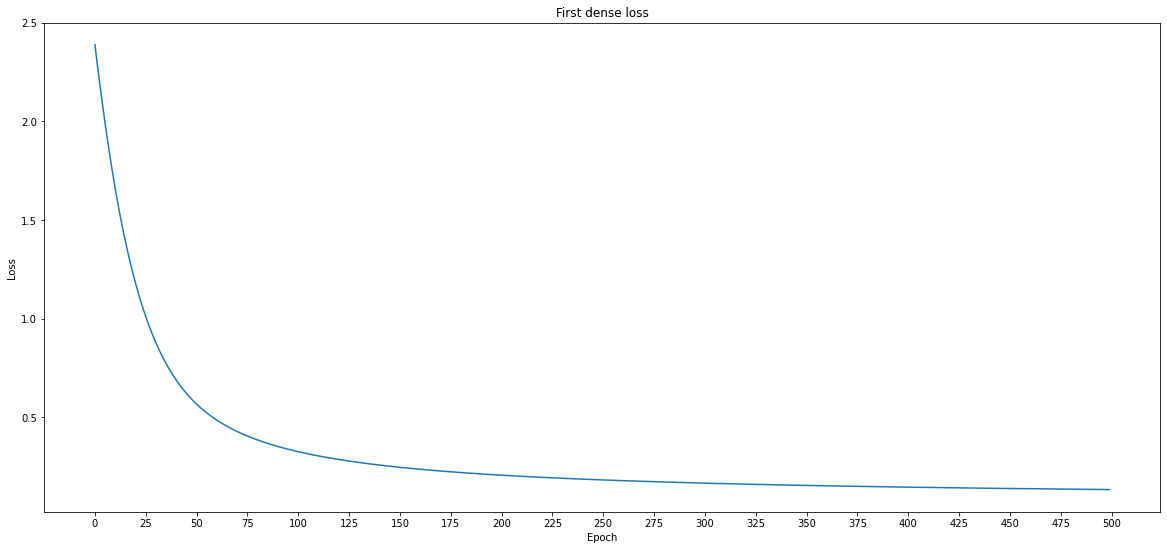

In [ ]:
plt.figure(figsize=(20, 9))
plt.plot(first_dense_readout_results)
plt.title('First dense loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, len(first_dense_readout_results)+1, 25))
plt.show()

In this case, differently from the previous ones the loss at the begginning is higher but soon it strongly decrease since reaching a very low value in the later epochs. This means that the last fully connected layer in the CNN is helping the model to take correct decisions. 

## 4.1Test the Linear Read-Outs

Now we use the test set to test the accuracy of each linear readout

In [ ]:
#test_hidden_CNN = get_hidden_representations(model_CNN, layer_names_CNN, X_test_norm[:1350])
test_hidden_CNN = get_hidden_representations( layer_names_CNN, X_test_norm)

85/85 [==============================] - 0s 3ms/step


In [ ]:
predictions_test_third_conv2D = linear_third_conv2D(test_hidden_CNN['third_conv2D'])
predictions_test_fourth_conv2D = linear_fourth_conv2D(test_hidden_CNN['fourth_conv2D'])
predictions_test_first_Dense = linear_first_Dense(test_hidden_CNN['first_dense'])

In [ ]:
#Compute the accuracy of the linear readout 
def compute_accuracy_linear_readout(predictions_test, targets, layer_type='conv'):
  accuracy = SparseCategoricalAccuracy()
  if layer_type == 'conv':
    accuracy.update_state(targets, predictions_test[:, 0, 0])
  elif layer_type == 'dense':
    accuracy.update_state(targets, predictions_test)
  accuracy = accuracy.result().numpy()
  return accuracy

In [ ]:
compute_accuracy_linear_readout(predictions_test_third_conv2D,y_test_conv,layer_type='conv')

0.52481484

In [ ]:
compute_accuracy_linear_readout(predictions_test_fourth_conv2D,y_test_conv,layer_type='conv')

0.7051852

In [ ]:
compute_accuracy_linear_readout(predictions_test_first_Dense,y_test_conv,layer_type='dense')

0.9077778

From the result above we can see a typical result for the linear readout of a CNN, in fact the accuracy of each linear readout increase as we descent in the deeper layers of the architecture. This means that the CNN as we go deep in the convolutional layers extract complex and increasingly representative feature maps, allowing the CNN to perform more accurate classifications. 
In fact also if the computation for the first and second layer that cannot be done we expect to obtain a lower accuracy on the first two convolutional layers in respect to the one obtained in the third layer.
Moreover, we can notice how the accuracy obtained by the last fully connected layer is quite similar to the one obtained by the CNN itself. For all these reasons, we can conclude that the model is performing also on test data, and it learned to make fairly accurate predictions.


# 5. Feature Visualization Method

In this section, we are going to explore the feature maps of the CNN.
In particular, a feature maps represents the output of a single layer of a CNN, where each one corresponds to a particular filter applied to the image and shows the activation of neurons that respond to the filter.

To achieve this objective, we use the Keract, a module which allows us to easily plot the feature maps of the various hidden layers.

[Keract documentation](https://github.com/philipperemy/keract)

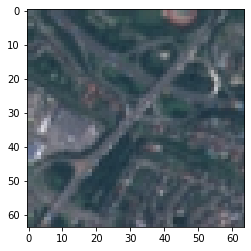

LABEL: 3
first_conv2D (1, 62, 62, 128) 


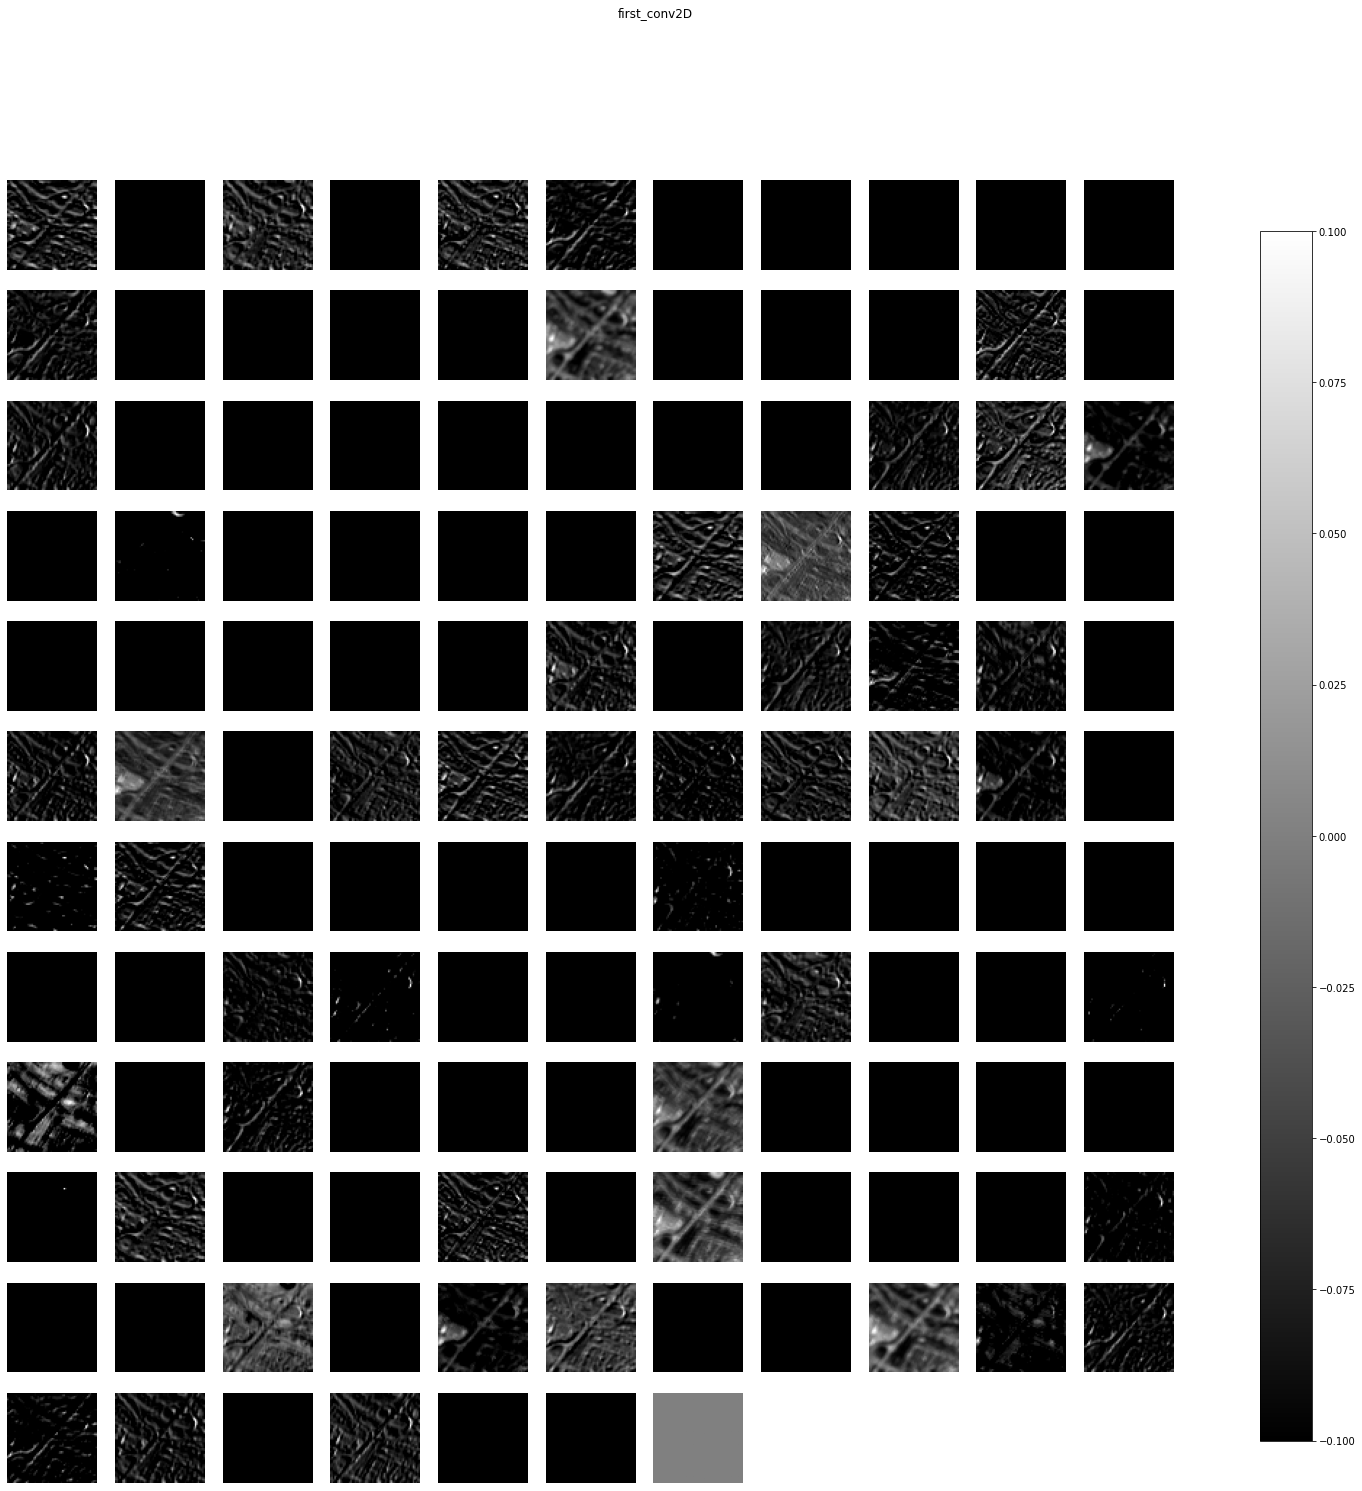

second_conv2D (1, 29, 29, 64) 


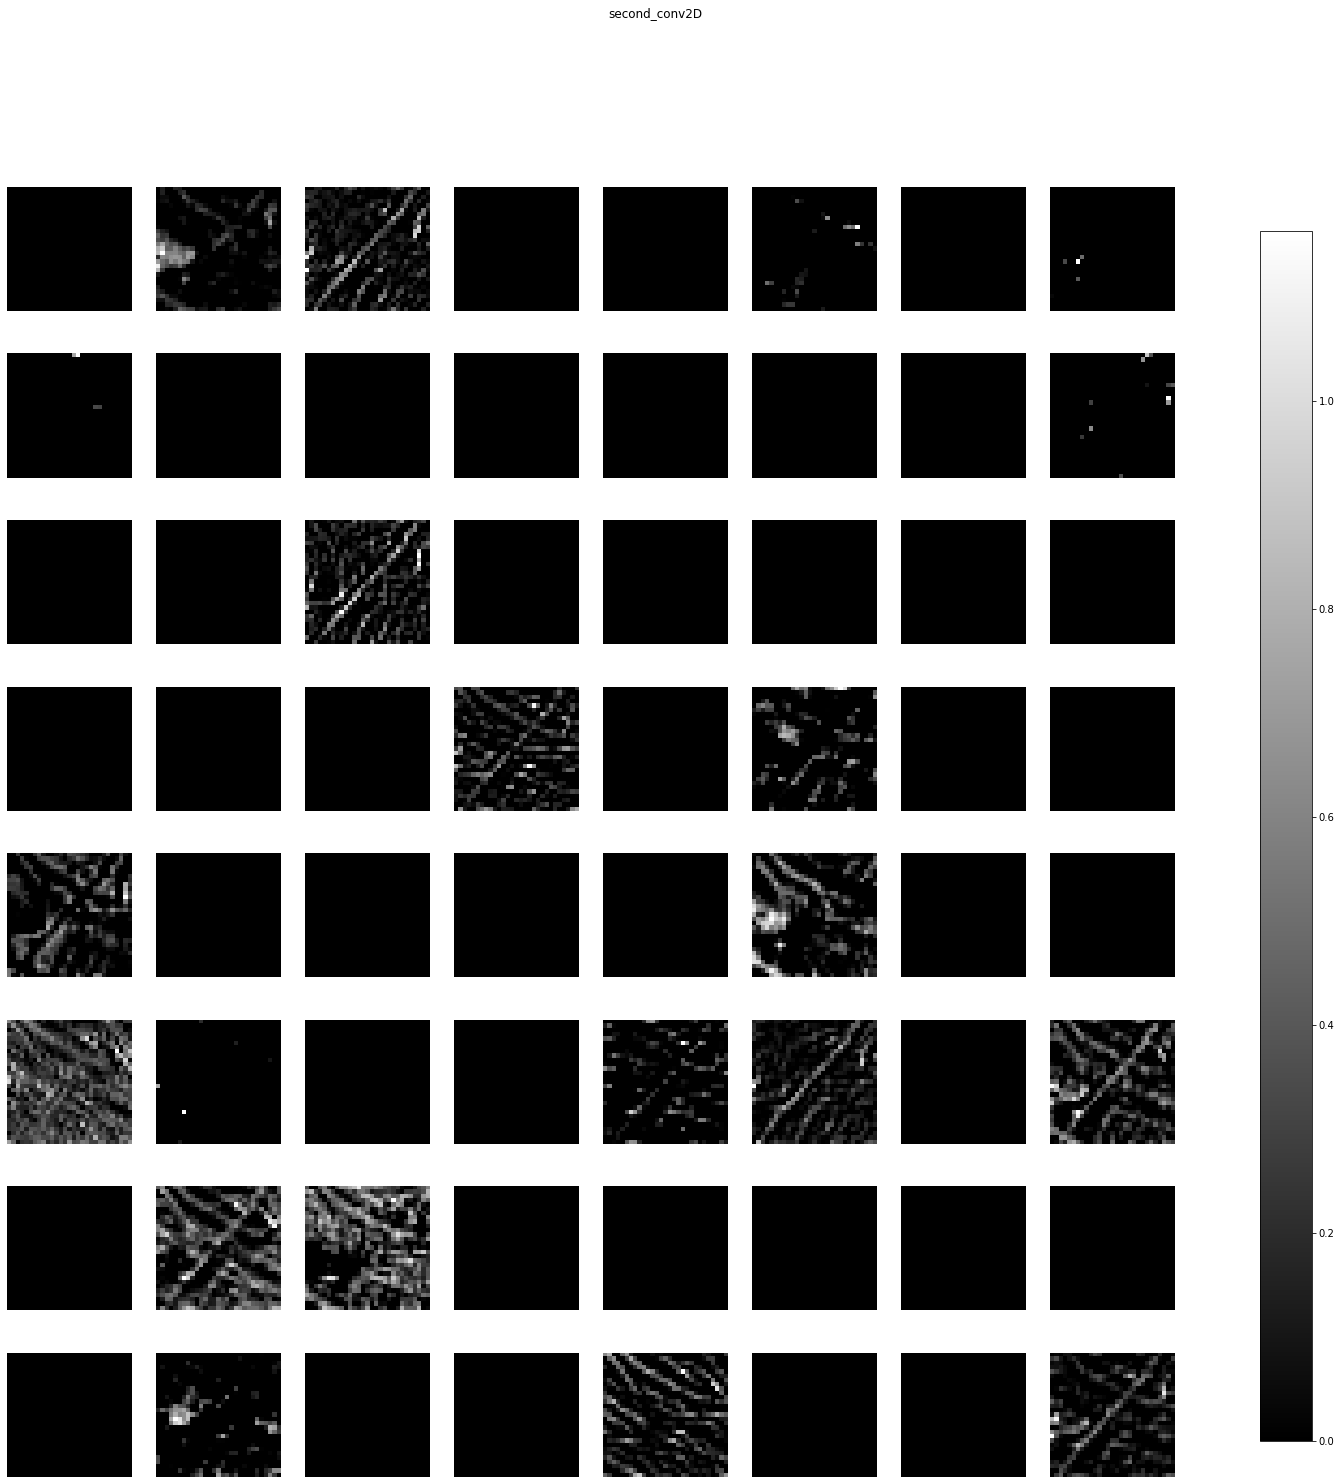

third_conv2D (1, 12, 12, 64) 


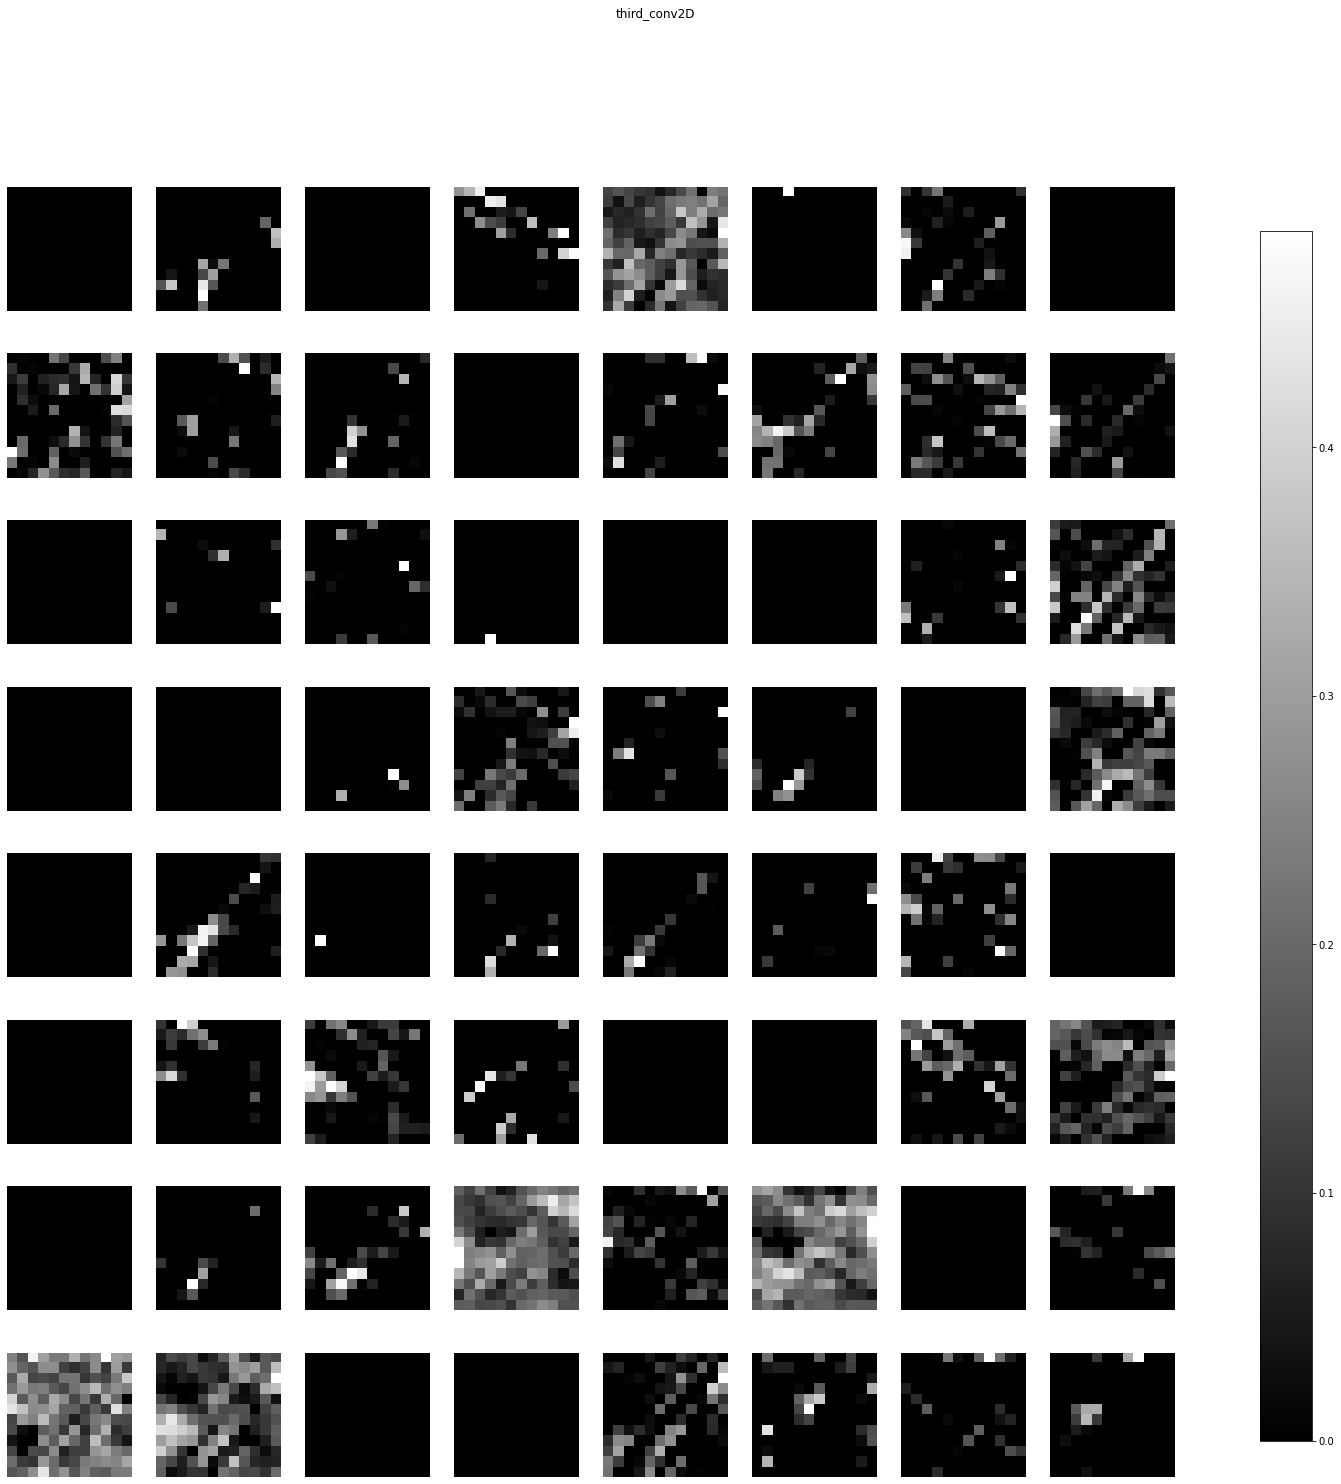

fourth_conv2D (1, 4, 4, 32) 


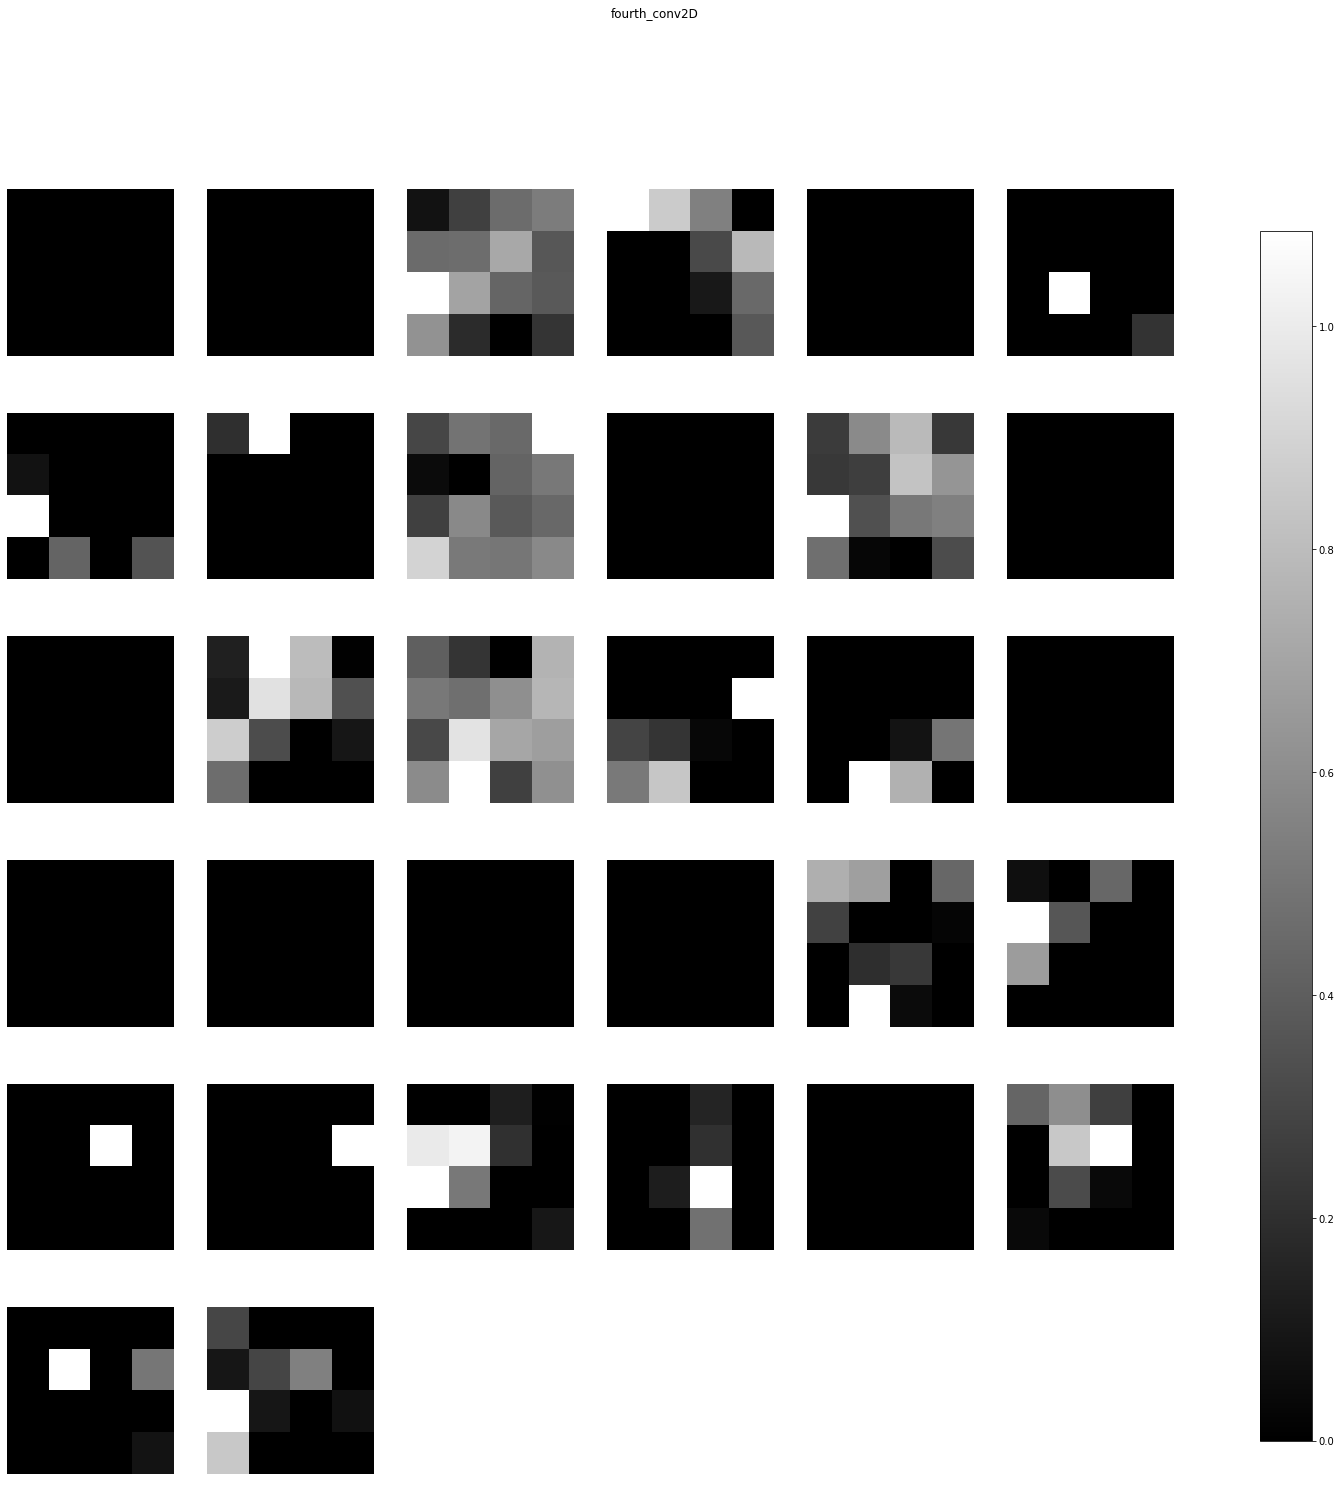

first_dense (1, 256) 


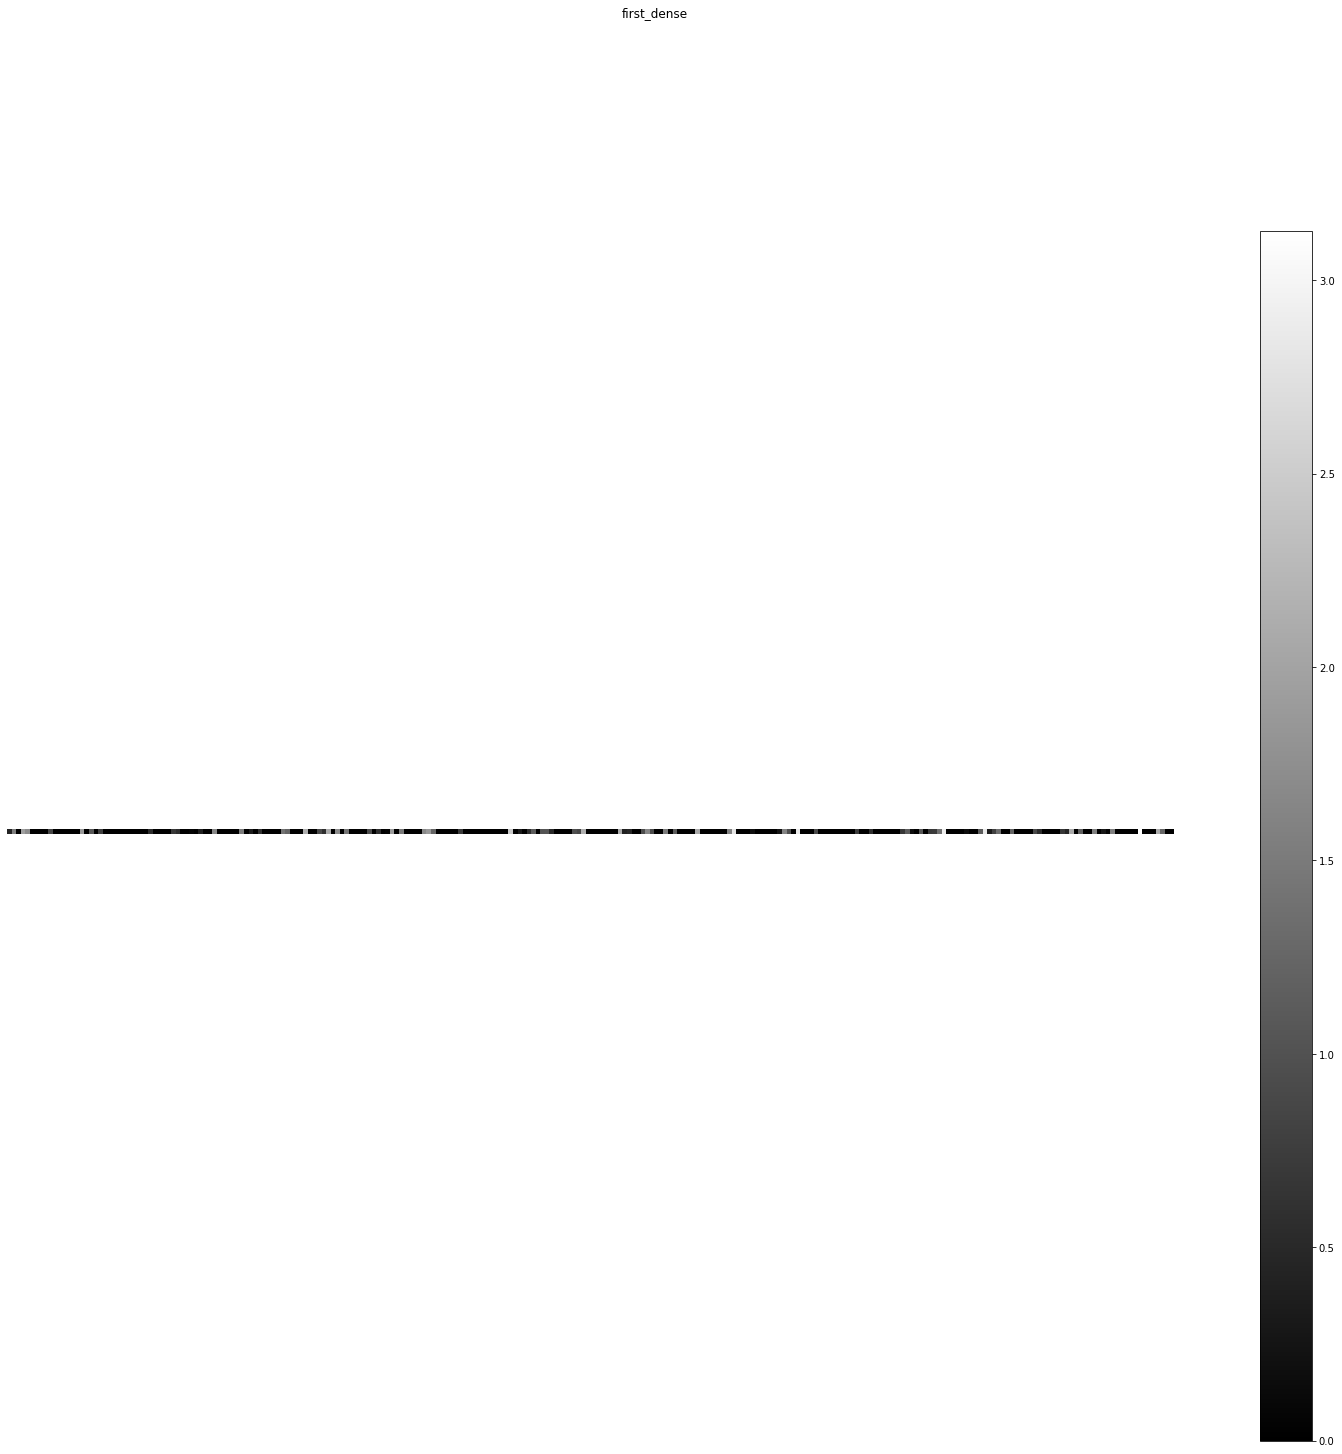

output (1, 10) 


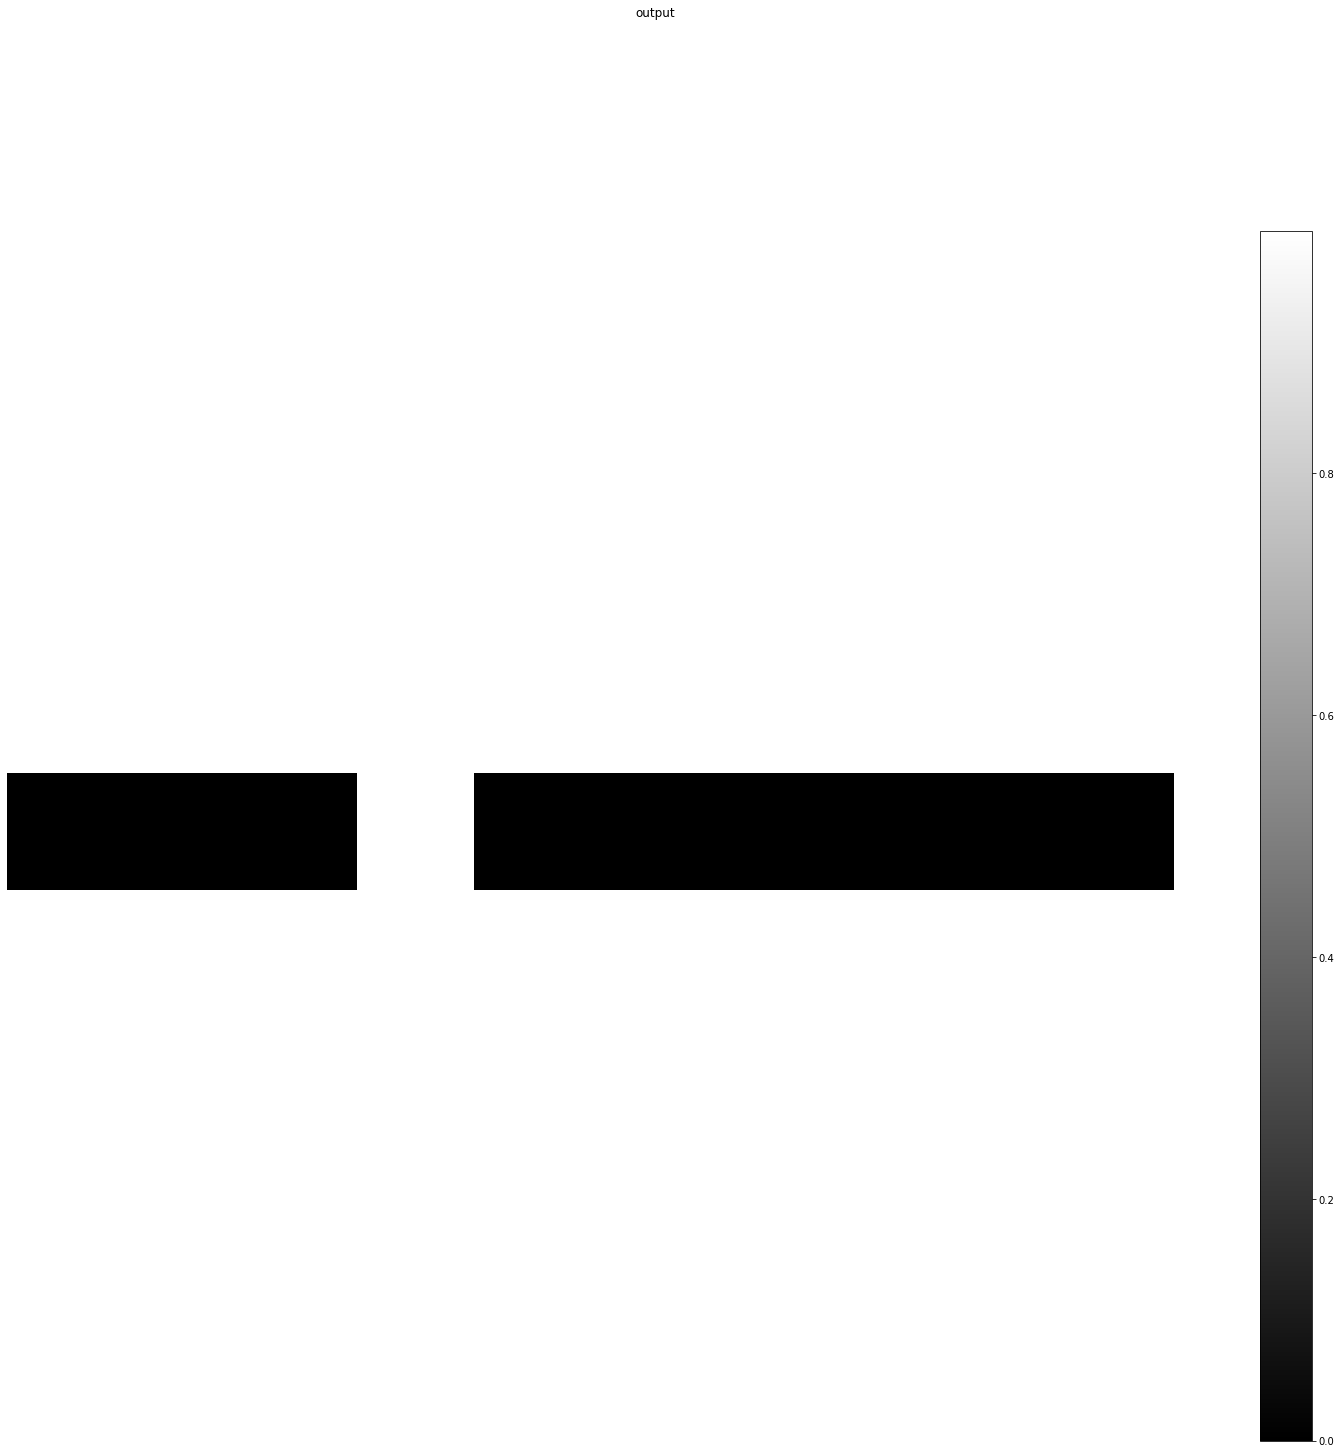

In [ ]:
keract_X = X_train_norm[4:5]
keract_y = y_train_conv[4:5]
layer_names=['first_conv2D', 'second_conv2D','third_conv2D', 'fourth_conv2D','first_dense', 'output']

activations_cnn = get_activations(model_CNN, keract_X, layer_names=layer_names)
#Plot the image and it's label
plt.imshow(keract_X[0],cmap = plt.cm.gray_r,interpolation = "nearest")
plt.show()
print("LABEL: %i"%keract_y[0])

#Plot the feature maps for each layer of the CNN
display_activations(activations_cnn, cmap='gray', save=False)

From the plotted feature maps of the first convolutional layer, we can see how the model highlight different features of the image, focusing on the deep of the lines or highlighting them in the 128 filters used in this layer. 
The black or almost black filters means that in the particular region in which it has been applied there is a very low activation value and the filter is not applied.

Going deep in the feature map, the filters become less and less significant to the human eyes, since the dimension of the image is reduced, and it shows less and less recognizable details.

# 6. Robustness to Gaussian noise

Now we will add Gaussian noise in the test set in order to evaluate the robustness of the model to random injected noise.

Injecting Gaussian noise in images means adding randomness to the pixel values, in this way each pixel is influenced by the random values of the Gaussian noise

1/1 [==============================] - 0s 30ms/step


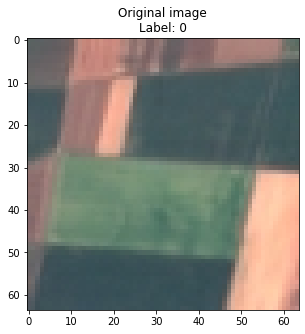

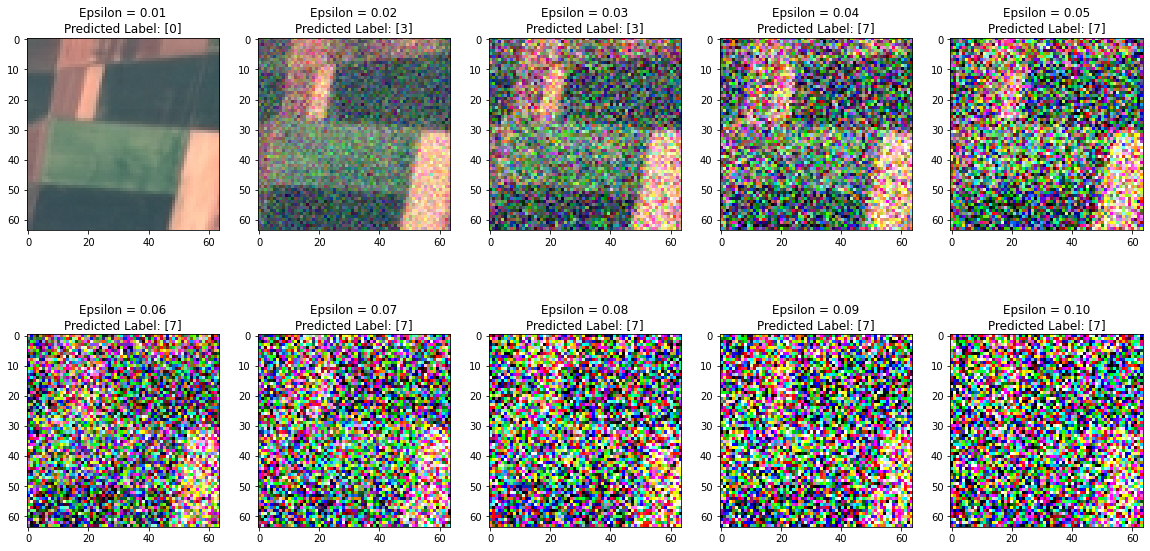

In [ ]:

#Plot the perturbed image and the associated predicted label
def plt_images(perturbed_images, predicted_labels):
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    for i, ax in enumerate(axs.flat):
      ax.imshow(perturbed_images[i])
      ax.set_title("Epsilon = {:.2f}\nPredicted Label: {}".format(0.01 + i * 0.01, predicted_labels[i]))


#Add gaussian noise to the image 
def add_noise_and_plot(model, feature, labels, max_noise):
    noise_level = 0.0
    #Accuracy level vector used to plot the psychometric curve
    noise_accuracies = []
    #First noised image of the set
    noised_first_image = []
    #First label of the noised set
    predicted_label_list = []

    #Increase noise level until reach max size
    while noise_level <= max_noise:
        #Add noise to the test set
        noised_features = feature + noise_level * np.random.normal(loc=0.0, scale=1.0, size=feature.shape)
        #Clip the values between 0 and 1
        noised_features = tf.clip_by_value(noised_features, 0, 1)
        #Take the first noised feature and store it in the collection
        noised_first_image.append(noised_features[0])

        #Evaluate the loss and the accuracy of the noised test set and store the accuracy
        accuracy = model.evaluate(noised_features, labels)[1]
        noise_accuracies.append(accuracy)

        #Make prediction of the first label of the noised test set and collect the predicted label
        predicted_label = np.argmax(model.predict(noised_features[:1]), axis=-1)
        predicted_label_list.append(predicted_label)

        #Increase the noise level by a factor of 0.1
        noise_level += 0.1

    #Plot the first images stored for each noise level
    plt_images(noised_first_image,predicted_label_list)
    plt.show()
    return noise_accuracies
  
#Plot the original image
def plt_original(original_image,original_label):
  plt.figure(figsize=(5,5))
  plt.imshow(original_image)
  plt.title("Original image\nLabel: "+str(original_label))

plt_original(X_test_norm[0],y_test_conv[0])

noise_accuracies=add_noise_and_plot(model_CNN,X_test_norm,y_test_conv,1.0)

As we can see from the plot above, adding Gaussian noise affect the image, making it blurry and less defined. For a noise level of 0.01 the prediction made by the model is still correct, but increasing the noise factor the same image is misclassified.
In fact, as we can see from the values obtained by the evaluation process, the accuracy level strongly decreases as noise level increase and in the same way the loss increase for higher values of noise.

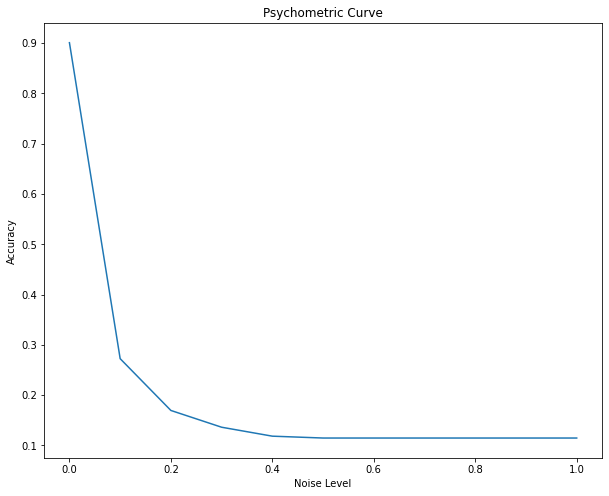

In [ ]:
#Plotting of the psychometric curve

plt.figure(figsize=(10,8))
plt.plot(np.arange(0, 1.1, 0.1), noise_accuracies)
plt.title('Psychometric Curve')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.show()


As already said, increasing the noise level, the accuracy of the model strongly decrease since reaching a constant value. 
In fact, we can conclude that the CNN is not performing well on noisy data, and it is very sensitive to it.


# 7. Adversarial Attacks - Fast gradient sign method

An adversarial attack is a specialized input for a Neural Network specifically create make the model misclassify such input. In particular, we implemented one of the most popular one that is the white box **Fast gradient sign method**.

In particular, the FGSM perturbs the original input image by adding a small amount of noise, which is calculated as the sign of the gradients of the loss function with respect to the input image to create a new image that maximize the loss. 

The following expression represent the FGSM attacks:

$ adv_x = x + \epsilon \cdot \text{sign}(\nabla_{x} J(θ, x, y))$

where:
* $adv_x$: output adversarial data;
* $x$: Original input image;
* $y$: Original input label;
* $\epsilon$: Multiplier to ensure the perturbations are small;
* $θ$: Model parameters;
* $J$: Loss.

Moreover, for small values of ϵ the perturbed images at human eyes appear identical to the original ones while the neural network often misclassify it. 

Fast Gradient Sign Method (FGSM): https://www.tensorflow.org/tutorials/generative/adversarial_fgsm.

Due to the size of the dataset and limited resources of Google Colab we decided to not perform the FGSM attack on the entire dataset, but only on some images for different values of epsilon. This approach should be sufficient to understand how the FGSM works and the resistance of the CNN previously created to this type of attack.

In [ ]:

#Perfrom the FGSM attack given the model, the feature, the label and a value of epsilon
def fgsm_attack(model, feature, label, epsilon):
    # Convert the label and feature to a tensor
    label = tf.constant(np.array([label]), dtype=tf.int32)
    feature = tf.constant(np.expand_dims(feature, axis=0), dtype=tf.float32)

    # Calculate the model loss for the given feature
    with tf.GradientTape() as tape:
        tape.watch(feature)
        pred = model(feature)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=label, y_pred=pred)
    # Calculate the gradient of the loss with respect to the given feature
    gradient = tape.gradient(loss, feature)
    # Normalize the gradient
    gradient = tf.sign(gradient)
    # Create the adversarial feature
    adversarial_feature = feature + epsilon * gradient
    # Clip the perturbed input to prevent it from going out of valid range
    adversarial_feature = tf.clip_by_value(adversarial_feature, 0, 1)
    return adversarial_feature

#Plot the perturbed images
def plt_images(perturbed_images, predicted_labels):
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    for i, ax in enumerate(axs.flat):
        ax.imshow(perturbed_images[i][0])
        ax.set_title("Epsilon = {:.2f}\nPredicted Label: {}".format(0.01 + i * 0.01, predicted_labels[i]))



def plt_original_and_perturbed(model,image,label):
  plt_original(image,label)
  #Starting with a small epsilon value in order to appear identical to the original at human eyes
  epsilon=0.010
  perturbed_list=[]
  predicted_label_list=[]
  #Perform the attack for different values of epsilon
  while epsilon<=0.1:
    print("For epsilon=",epsilon)
    #Perform the FGSM attack on the given input and collect the output in the list
    perturbed_image=fgsm_attack(model, image, label, epsilon)
    perturbed_list.append(perturbed_image)

    #Predict the perturbed feature and store it
    predicted_label = np.argmax(model.predict(perturbed_image))
    predicted_label_list.append(predicted_label)
    #Increase the epsilon value
    epsilon+=0.010
  #Plot the perturbed images and the predicted labels
  plt_images(perturbed_list,predicted_label_list)

For epsilon= 0.01
1/1 [==============================] - 0s 23ms/step
For epsilon= 0.02
1/1 [==============================] - 0s 19ms/step
For epsilon= 0.03
1/1 [==============================] - 0s 18ms/step
For epsilon= 0.04
1/1 [==============================] - 0s 24ms/step
For epsilon= 0.05
1/1 [==============================] - 0s 29ms/step
For epsilon= 0.060000000000000005
1/1 [==============================] - 0s 21ms/step
For epsilon= 0.07
1/1 [==============================] - 0s 23ms/step
For epsilon= 0.08
1/1 [==============================] - 0s 20ms/step
For epsilon= 0.09
1/1 [==============================] - 0s 20ms/step
For epsilon= 0.09999999999999999
1/1 [==============================] - 0s 27ms/step


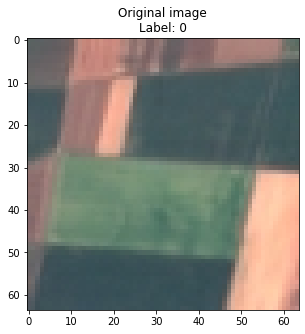

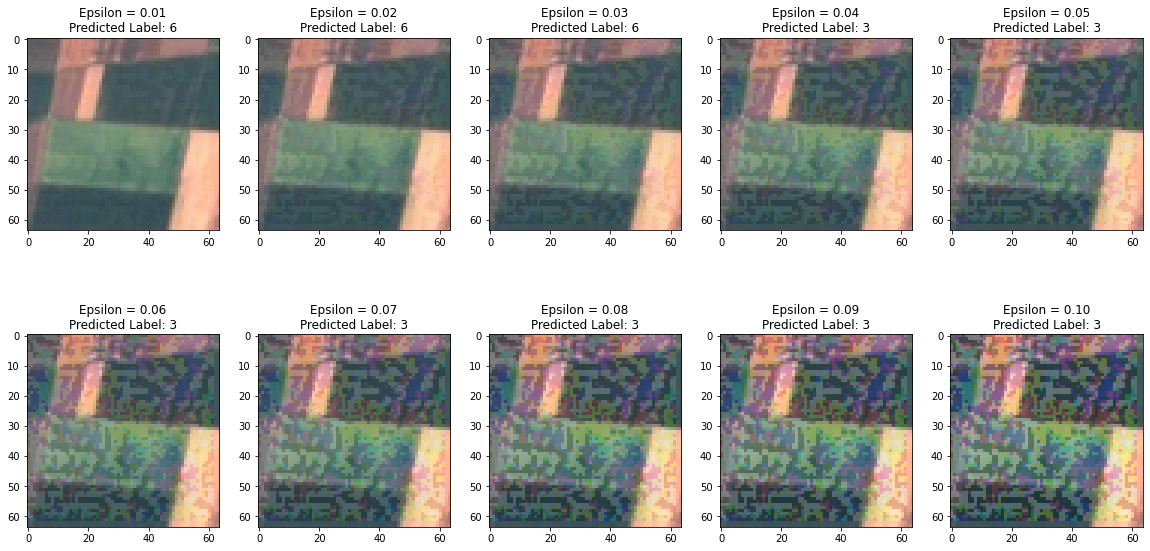

In [ ]:
plt_original_and_perturbed(model_CNN,X_test_norm[0],y_test_conv[0])

As expected the image for small ϵ values remain identical to the human perspective, while increasing the value of ϵ the different elements that form the images remain distinguishable, the effect of the injection is clearly visible.
The attack is gone well, in fact the model misclassify the image for each value of ϵ, changing the predicted label as the ϵ factor increase.
We can conclude that the CNN has a very low resistance to this type of attacks, but probably adopting data augmentations techniques, regularization or training the model on perturbed or on adversarial samples could help the CNN to resist to this type of attacks.

# 8. CAE—Convolutional Autoencoder
In this section, a Convolutional Auto Encoder is defined in order to perform image denoising.
In general, an autoencoder is an unsupervised neural network used to reduce the dimensionality of the data received in input by learning a compressed representation of it and reconstructing the original data starting from the compressed representation.

In an autoencoder, there are two main parts:

*   Encoder:Take the original image and transform it into a compressed representation
*   Decoder: Take the output of the encoder and reconstruct the original input from the compressed representation

In particular, the encoder is made by 2 convolutional layers with 32 filters of dimension 3×3, followed by 2 max pooling layers in order to reduce the output dimension by a factor of 2.

Similarly, the decoder is made by 2 convolutional layers with the same dimension of the others, followed by 2 layers of up-sampling in order to reconstruct the image. In the end, a convolutional layer with 3 filters of size 3×3 reconstruct the original image.

The autoencoder is then compiled using 'Adam' as optimizer and the loss function 'MeanAbsoluteError' that calculates the mean of the absolute difference between the original image and the reconstructed.




In [ ]:
#Function to create an autoencoder
def create_model():
  input_image = tf.keras.Input(shape=(64, 64, 3))

  #Encoding phase
  x = Conv2D(32, 3, activation='relu', padding='same', name='encoder_first_conv')(input_image)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(16, 3, activation='relu', padding='same', name='encoder_second_conv')(x)
  encoded = MaxPooling2D(2, padding='same')(x)
  #The image now is reduced to size: (None, 16, 16, 16)
  print(encoded.shape)

  #Decoding phase
  x = Conv2D(16, 3, activation='relu', padding='same',name='decoder_first_conv')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, 3, activation='relu', padding='same',name='decoder_second_conv')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='last_conv')(x)
  autoencoder = tf.keras.Model(input_image, decoded)
  autoencoder.compile(optimizer='adam', loss='mean_absolute_error')
  return autoencoder

autoencoder_layer_names = ['encoder_first_conv','encoder_second_conv','decoder_first_conv','decoder_second_conv','last_conv']


In [ ]:
autoencoder = create_model()

(None, 16, 16, 16)


In [ ]:

noise_level = 0.3

#Insert noise in the training set
X_train_noisy = X_train_norm + noise_level * np.random.normal(loc=0.0, scale=1.0, size=X_train_norm.shape)

#Insert noise in the validation set
X_validation_noisy = X_validation_norm + noise_level * np.random.normal(loc=0.0, scale=1.0, size=X_validation_norm.shape)

#Force the pixel value to be between 0 and 1
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_validation_noisy = np.clip(X_validation_noisy, 0., 1.)

In order to train the autoencoder to denoise noisy images we use the training set in which we inserted gaussian noise as feature and the normal one as label. In this way the encoder should train to represent the noisy image in a compact way and apply an inverse transformation to reconstruct the image without the inserted noise.

In [ ]:
#Training the encoder on noisy train set allow it to performs better on noisy images and reconstruct them in a better way 
autoencoder_results=autoencoder.fit(X_train_noisy, X_train_norm,
                epochs=10,
                batch_size=128,
                shuffle=False,
                validation_data=(X_validation_noisy, X_validation_norm)
                )

Epoch 1/10
169/169 [==============================] - 10s 38ms/step - loss: 0.0639 - val_loss: 0.0458
Epoch 2/10
169/169 [==============================] - 5s 29ms/step - loss: 0.0429 - val_loss: 0.0411
Epoch 3/10
169/169 [==============================] - 5s 29ms/step - loss: 0.0392 - val_loss: 0.0389
Epoch 4/10
169/169 [==============================] - 5s 28ms/step - loss: 0.0378 - val_loss: 0.0379
Epoch 5/10
169/169 [==============================] - 5s 29ms/step - loss: 0.0370 - val_loss: 0.0373
Epoch 6/10
169/169 [==============================] - 5s 28ms/step - loss: 0.0365 - val_loss: 0.0368
Epoch 7/10
169/169 [==============================] - 5s 29ms/step - loss: 0.0361 - val_loss: 0.0365
Epoch 8/10
169/169 [==============================] - 5s 28ms/step - loss: 0.0357 - val_loss: 0.0361
Epoch 9/10
169/169 [==============================] - 5s 28ms/step - loss: 0.0352 - val_loss: 0.0355
Epoch 10/10
169/169 [==============================] - 5s 29ms/step - loss: 0.0349 - val_l

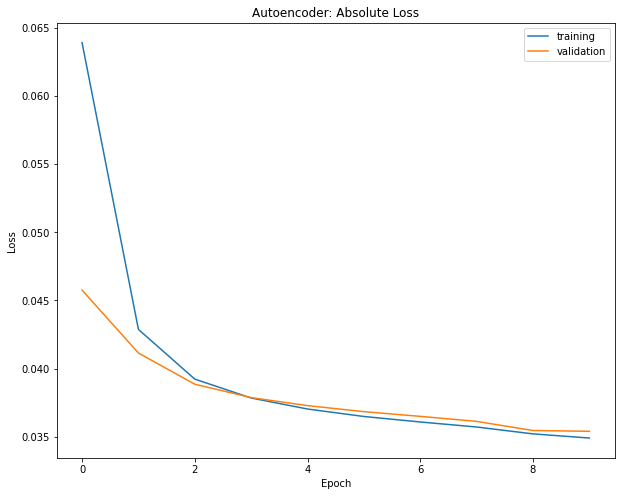

In [ ]:
 #Store the loss of the training and validation set
training_loss = autoencoder_results.history['loss']
validation_loss = autoencoder_results.history['val_loss']

#Loss history for training and validation
plt.figure(figsize=(10, 8))
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Autoencoder: Absolute Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

We performed the training for 10 epochs, but the loss value of training and validation set after an initial drop remain slowly in the decreasing.

85/85 [==============================] - 1s 3ms/step


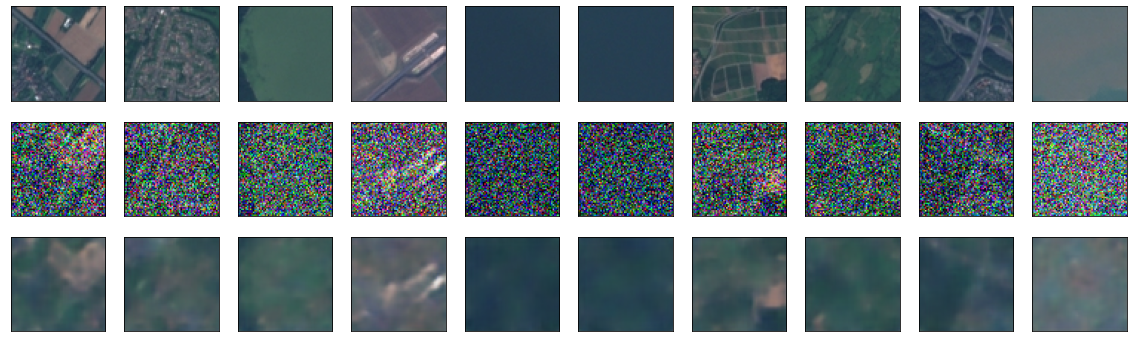

In [ ]:
#Insert Gaussian noise in the test set
X_test_noisy = X_test_norm+noise_level * np.random.normal(loc=0.0, scale=1.0, size=X_test_norm.shape)

#Force the pixel to assume values between 0 and 1
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

#Perform prediction on the noisy test data 
decoded_imgs = autoencoder.predict(X_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(1, n + 1):
    # Display Original images
    ax = plt.subplot(3, n, i)
    plt.imshow(X_test_norm[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display perturbed images
    ax = plt.subplot(3, n, i+n)
    plt.imshow(X_test_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + (2*n))
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



As we can see from the plot above, the reconstructed images look strongly blurred, moreover depending on the image structure some particular elements remain distinguishable but not recognizable. In general, we can say that the decoder is not performing in an excellent way and for higher values of “noise level” we expect even more blurry and defined images.

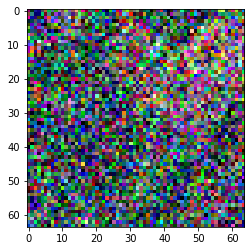

encoder_first_conv (1, 64, 64, 32) 


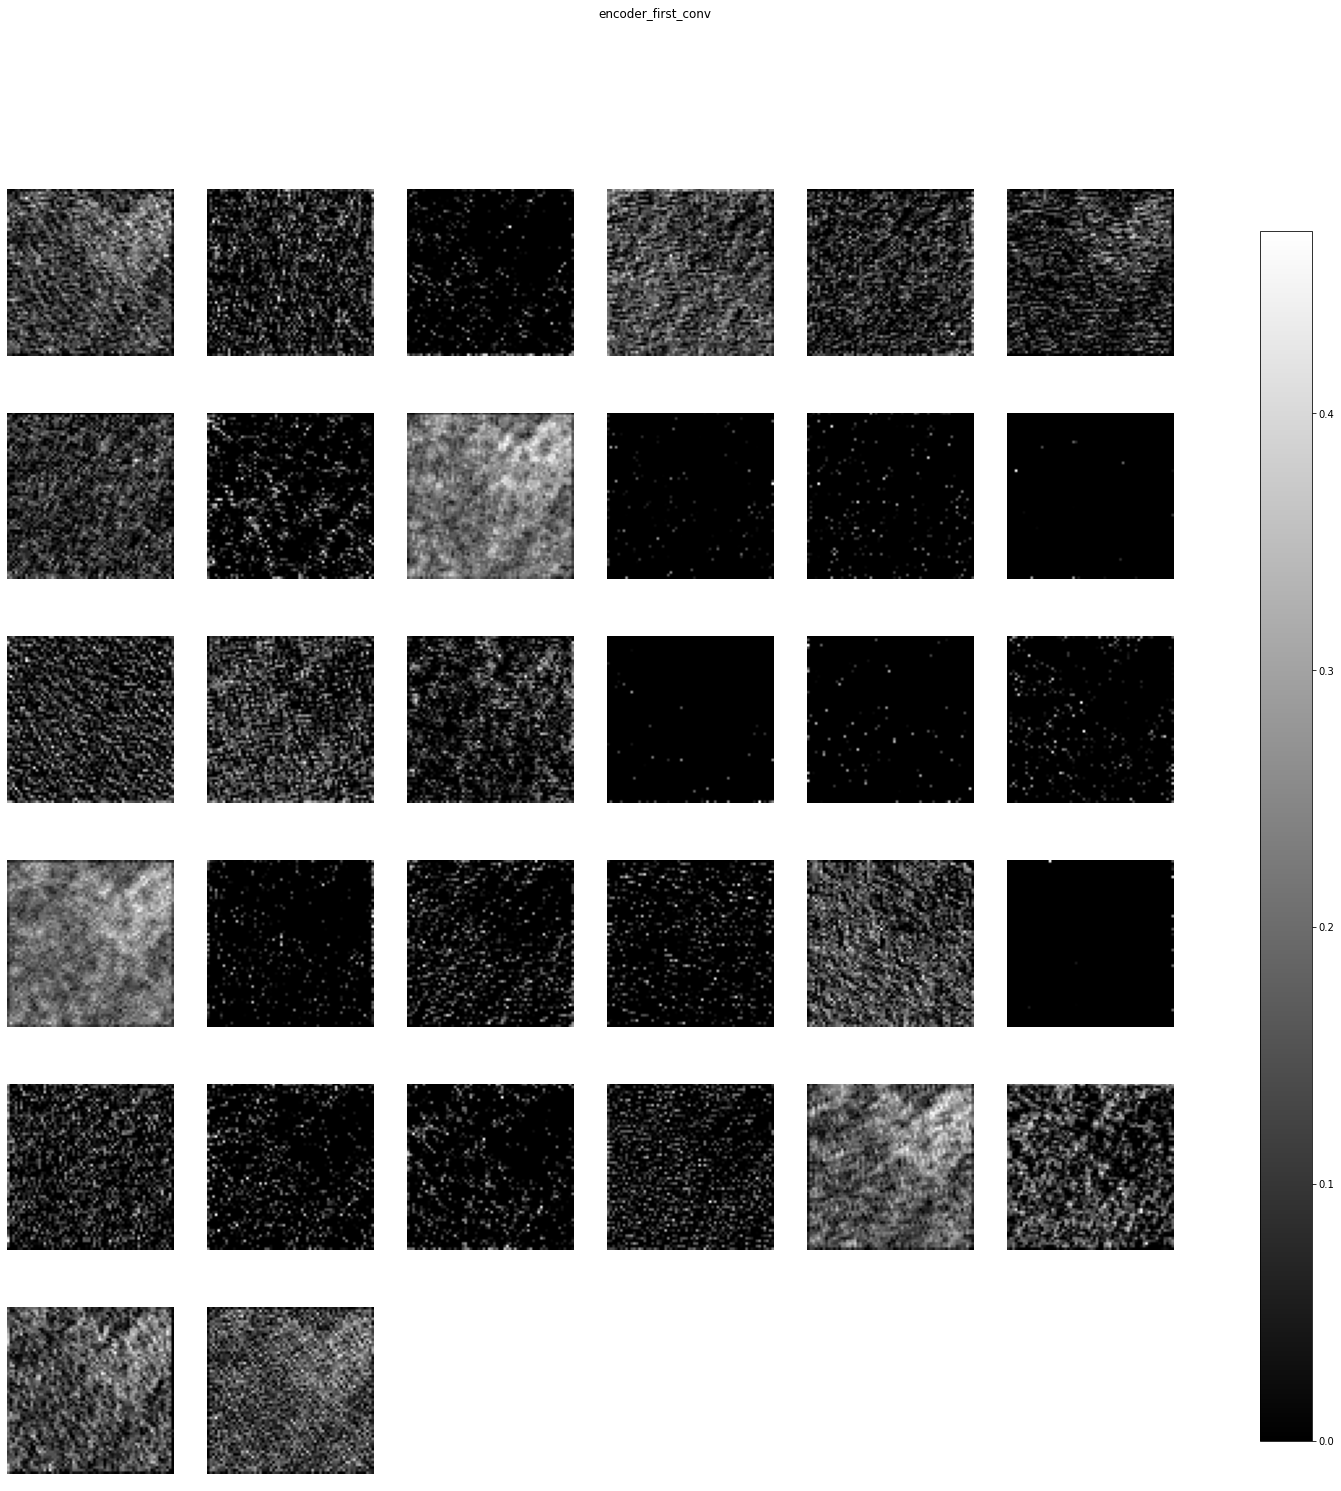

encoder_second_conv (1, 32, 32, 16) 


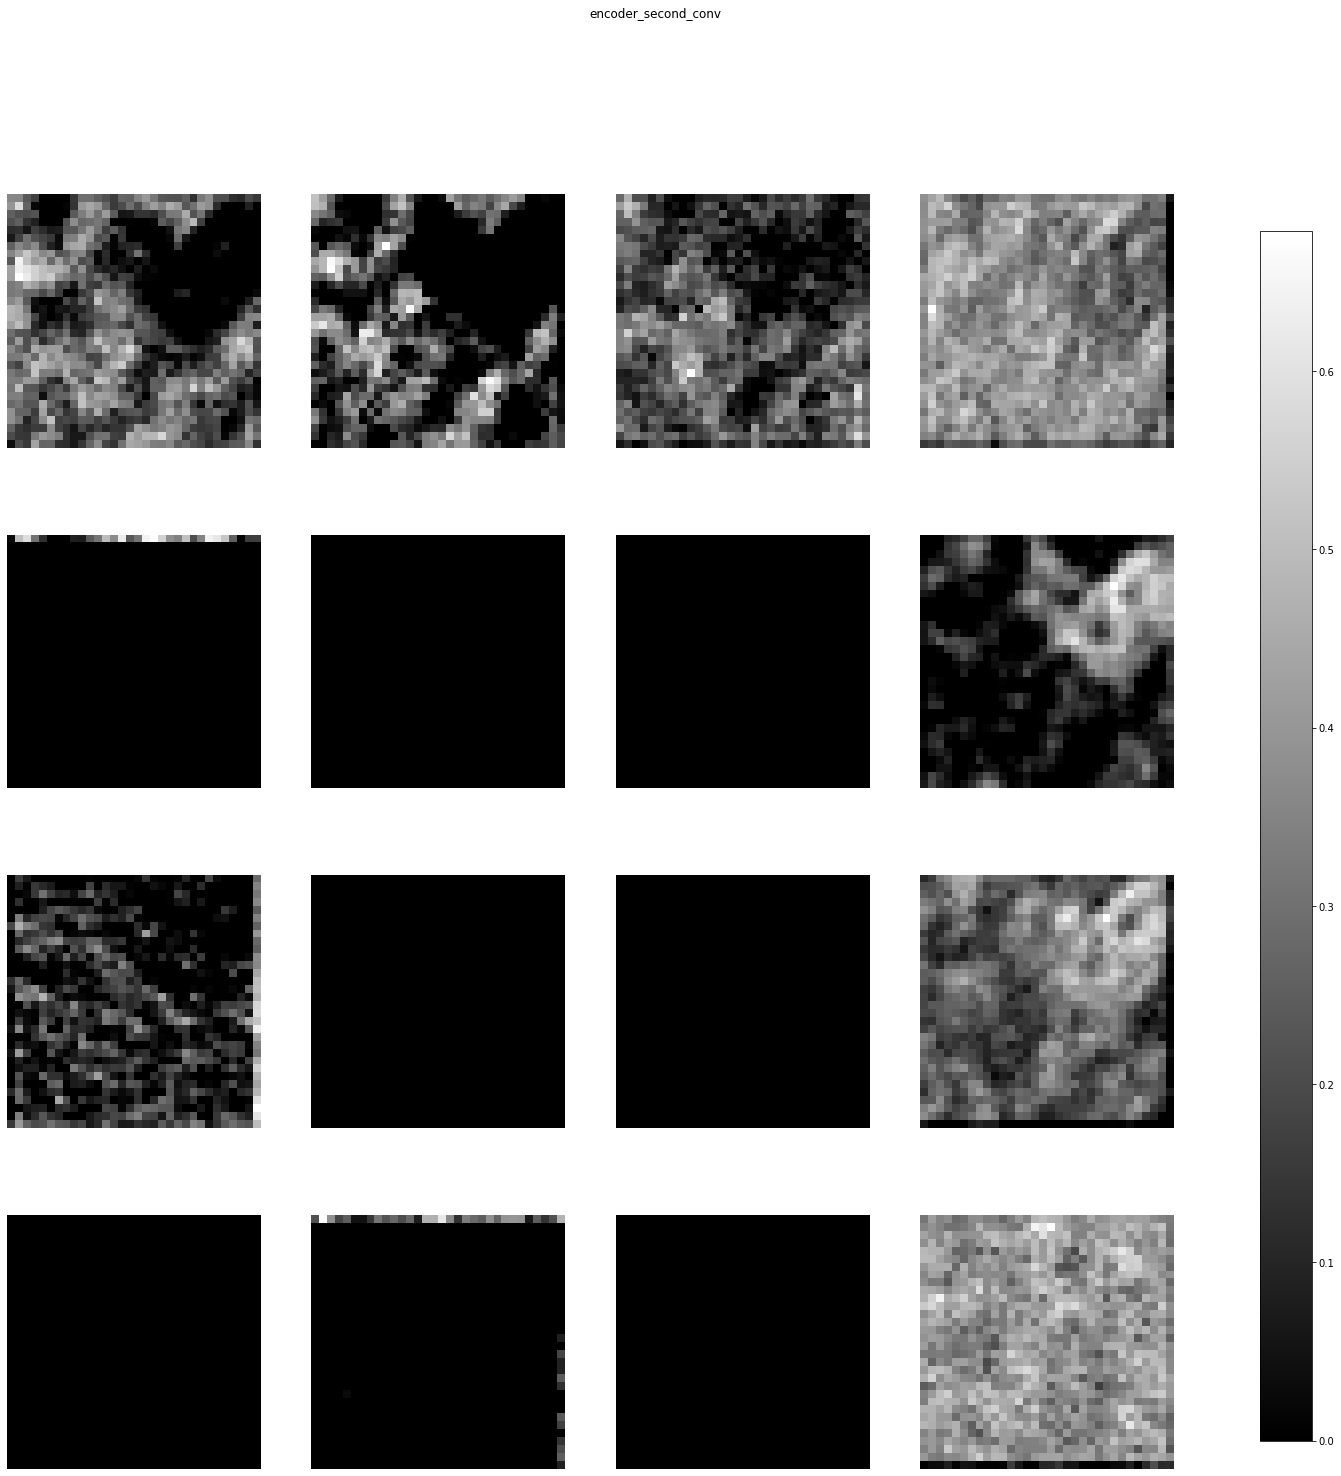

decoder_first_conv (1, 16, 16, 16) 


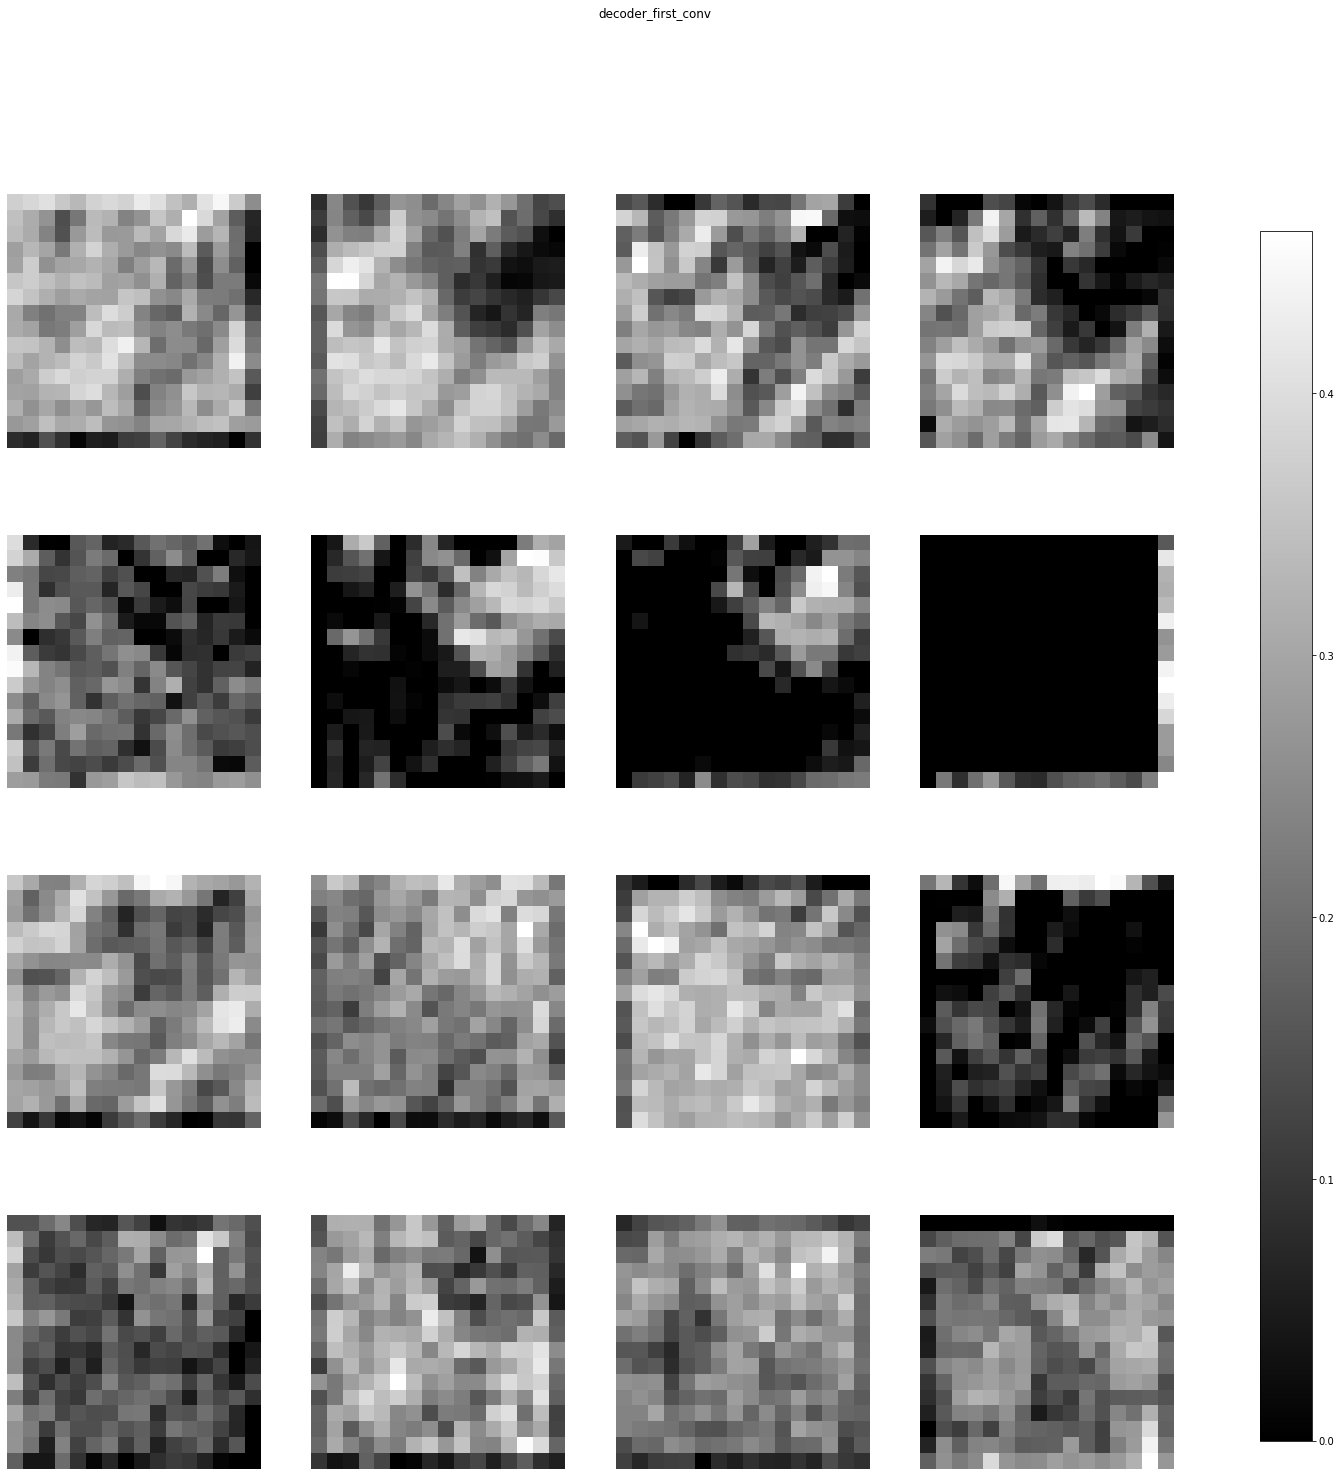

decoder_second_conv (1, 32, 32, 32) 


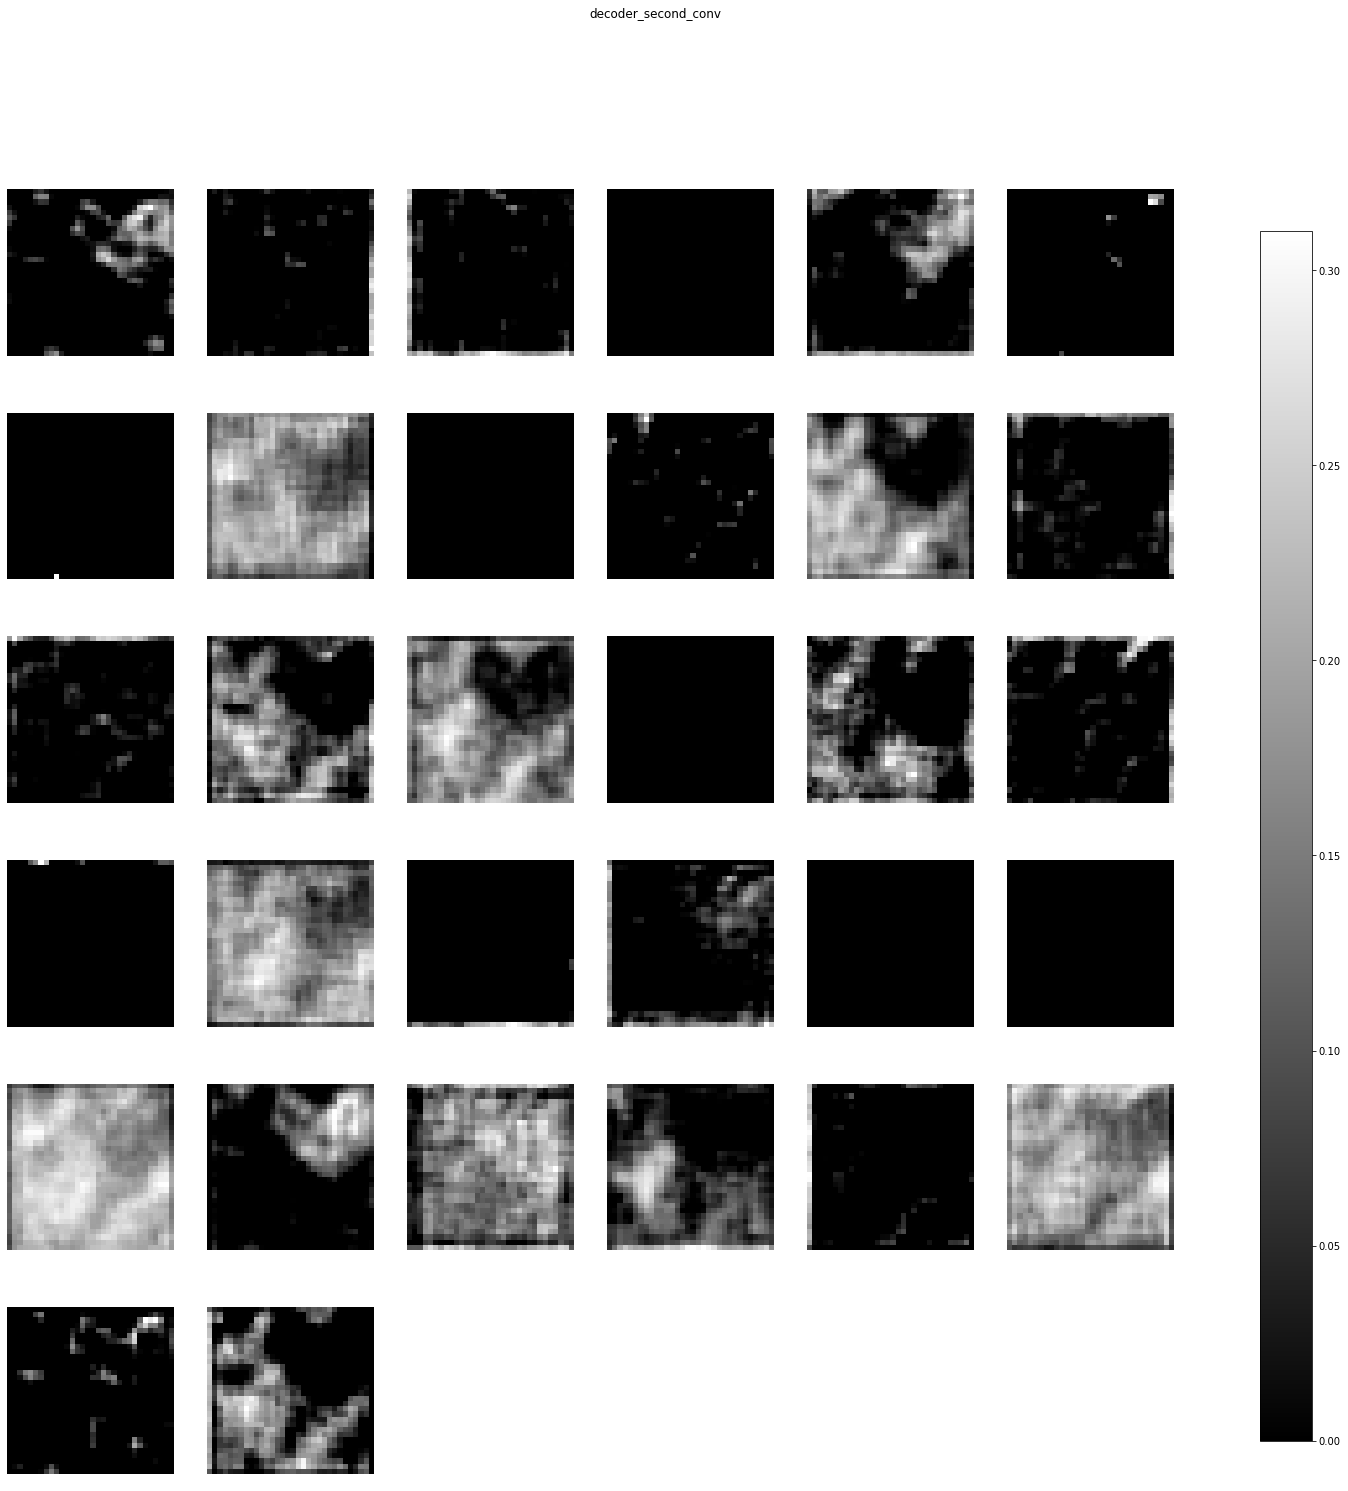

last_conv (1, 64, 64, 3) 


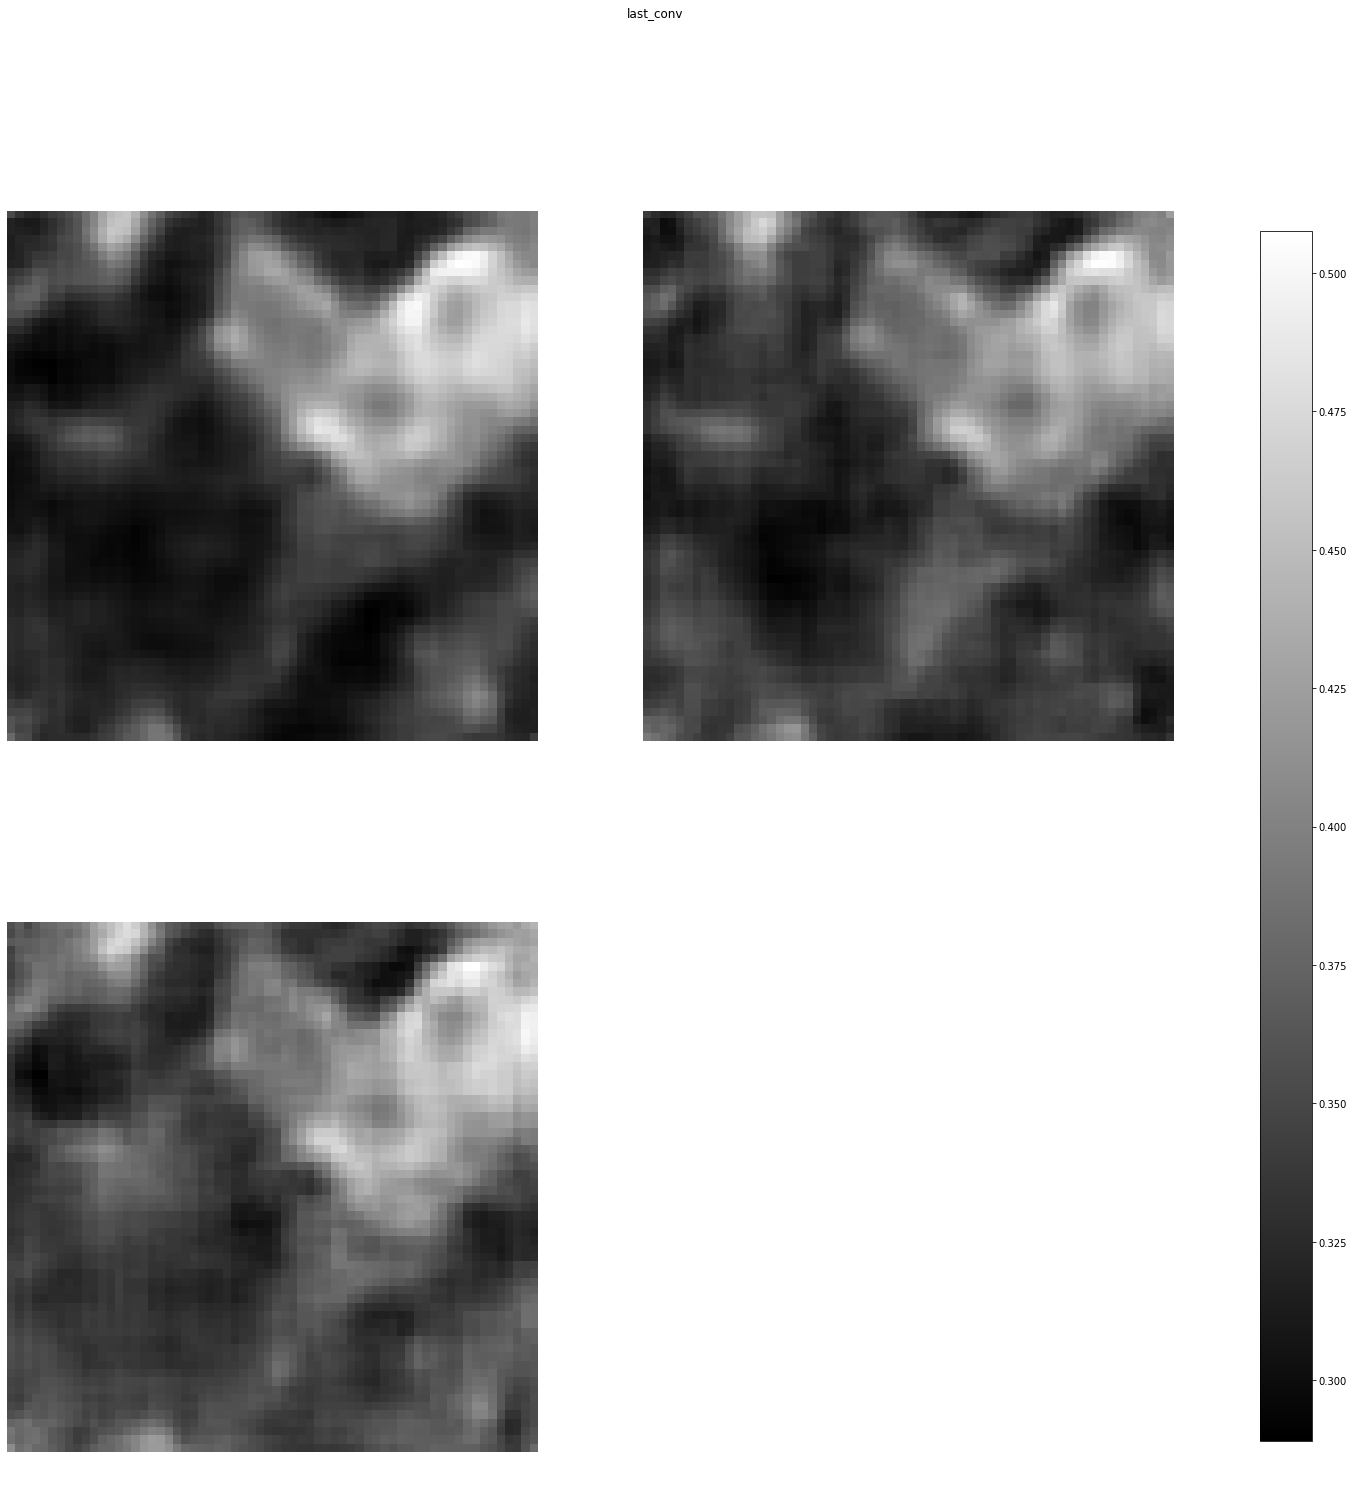

In [ ]:
keract_inputs = X_test_noisy[1:2]

activations_cnn = get_activations(autoencoder, keract_inputs, layer_names=autoencoder_layer_names)
#Plot the image and it's label
plt.imshow(keract_inputs[0],cmap = plt.cm.gray_r,interpolation = "nearest")
plt.show()

#Plot the feature maps for each layer of the CNN
display_activations(activations_cnn, cmap=None, save=False)

From the plotted features maps of the encoder, we cannot recognize any elements highlighted by the filters. The decoder only shows us some major details of the image that still remain too much blurred.

In [ ]:
#Make predictions on the decoded_images by the autoencoder
res_test=model_CNN.evaluate(decoded_imgs,y_test_conv)

85/85 [==============================] - 1s 5ms/step - loss: 5.7545 - sparse_categorical_accuracy: 0.2733


For a noise level of 0.3 on test data, we still obtain a low level of accuracy using the CNN to make predictions. Anyway, this is a slightly higher result than the one obtained using directly the noisy data to test the CNN with the same noise level. In fact, in that case we obtained a loss of 32.4128 and an accuracy of 0.1363.

In any case these results cannot be considered a success , in fact the autoencoder is not performing well on this dataset and that probably the best technique to increase the resistance of the CNN is to use a more complex autoencoder architecture or in general other techniques of noise removal.